In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans
import imageio

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import same_mov_inds, get_interp_filename
from tools_lnd import bifurc, plot_bifurc_ends, take_names, gen_mov_trial_set, make_D_use, gen_trials_from_model_dir
from tools_lnd import make_D_use, interp3d, take_names, comp_eig_decomp, axis_label_bifurc, title_label_bifurc
from tools_lnd import same_stim_trial, get_T_inds, gen_X_from_model_dir, check_plot_zero_plane, adjust_ax

In [2]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'mem_motifs_small'
rule_trains = rules_dict[ruleset]
n_tasks = str(len(rule_trains))
rule_trains_str = '_'.join(rule_trains)
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '0'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# net_name = 'lr7.0l2_w6.0_h-0.0_fdgo_fdanti'
data_folder = 'data/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [3]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig1','fig1_two_task_bifurc_mov')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [17]:
q_thresh = 1e-8
tol_q = 1e-6
offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]
rule_axs = 0
rule_set = [5,2]
trial_set = gen_mov_trial_set(m,rule_set)
epoch_set = ['delay1','delay1']
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]

rule1 = rules_dict['all'][rule_set[0]]
rule2 = rules_dict['all'][rule_set[1]]
rule_str = [rule1,rule2]

ax_labels = 'pca_h'
D_fix = make_D_use(m,rule,'stim1',ti,ax_labels)
D_use = D_fix

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

In [19]:
np.shape(D_use)

(256, 3)

In [29]:
def bifurc_mov(m,D_use,rule_set,epoch_set,t_set = [0,0],script_name = 'interp_tasks_small_init_mov',
           cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['w','k'],q_thresh = .001,
           n_skip_interps=1, rule_axs = 0,ax_labels = 'pca_h', plot_unstable = True,
           color_stim = True,fig_size = 4, fontsize = 20, figpath = [],ruleset = [],
           title_y = .9, n_interp = 20,n_trials = 0, stability_thresh = 1, threeD = True,
           lims = [], view_ang = [],lw = 6,ms = 6,linestyle = '-',al_state = 1,al_fp = 1, 
           bifurc = True, plot_zero_plane = False, tol_q = 1e-6,plot_fps = True):
    
    LAG = 5 
    plt.rcParams.update({'font.size': fontsize})

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
    
    tit, tit_name, tit_save = title_label_bifurc(bifurc,epoch_name1,epoch_name2,rule_name1,
                                                 rule_name2,ruleset,title_y,fontsize)

    movie_dir = os.path.join(figpath,tit_save,tit_name,'ends')
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)

    T_inds = get_T_inds(trial1,epoch_set[0])
    movie_inds = range(T_inds[0],T_inds[-1]) #frame every 6 timesteps
    print(T_inds,movie_inds)
    
    if plot_fps:
        mov_i = 33
        im_start = len(movie_inds)-1
    else:
        mov_i = 0
        im_start = 0
        
    for im_num in range(im_start,len(movie_inds),1):
        
        fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
        if threeD:
            ax = fig.add_axes([0,0,1,1], projection='3d');
        else:
            ax = fig.add_axes([0,0,1,1]);

        axis_label_bifurc(ax,ax_labels,rule_name_ax,epoch_name_ax,bifurc,threeD,fontsize)    
        adjust_ax(ax,lims,threeD,bifurc,plot_zero_plane,view_ang)

        for ri in range(2):

            cd = cmap_discrete[ri]
            trial = gen_trials_from_model_dir(m,rule_str[ri],mode='test',noise_on = False)

        #plot trajectory
            if plot_fps:
                plot_set = range(T_inds[-1]-LAG,T_inds[-1])
            else:   
                plot_set_start = np.max([movie_inds[0],im_num-LAG])
                print(plot_set_start)
                plot_set = range(plot_set_start,im_num+1)

            #get traj
            _,x = gen_X_from_model_dir(m,trial)
            x_epoch = np.transpose(x,(1,2,0))

            #get state colors
            cmap_state = plt.get_cmap('hsv')
            if color_stim:
                c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
                s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
                c = cmap_state(c_set[s]/(2*np.pi))
            else:
                c_set = trial.y_loc[-1,:]
                s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
                c = cmap_state(c_set[s]/(2*np.pi))

            #plot other trials   
            if n_trials==0:
                trial_set = range(0)
            else:
                trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/n_trials))

            for trial_i in trial_set:
                ci = cmap_state(c_set[trial_i]/(2*np.pi))
                x_traj_i = np.dot(x_epoch[trial_i,:,:],D_use)
                if bifurc:
                    x_traj_i[:,2] = x_traj_i[:,1]
                    x_traj_i[:,1] = x_traj_i[:,0]
                    x_traj_i[:,0] = ri*np.ones(len(x_traj_i))

                    
                print(np.shape(x_traj_i),plot_set)
                plot_bifurc(ax,x_traj_i,threeD,plot_set,c = ci,cd = cmap_discrete[ri],lw = lw*2,ms = ms)

#             #plot fp trial
#             x_traj = np.dot(x_epoch[s,:,:],D_use)
#             if bifurc:
#                 x_traj[:,2] = x_traj[:,1]
#                 x_traj[:,1] = x_traj[:,0]
#                 x_traj[:,0] = ri*np.ones(len(x_traj))

#             plot_bifurc(ax,x_traj, threeD, plot_set, c = c, cd = cmap_discrete[ri],lw = lw*2,ms = ms)

        mov_i += 1 
        plt.savefig(movie_dir +'/'+ str(mov_i) + '.png', dpi=300)


    #plot fps
    if plot_fps:
        for step_i in range(0,n_interp,n_skip_interps):
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                fp = np.dot(sorted_fps[fp_ind,:],D_use)
                facecolors_3d = c
                fp_s = 50

                if bifurc:
                    fp[2] = fp[1]
                    fp[1] = fp[0]
                    fp[0] = step_i/n_interp

                #sometimes we don't want to distinguish marginally stable fps so threshold is variable
                if np.max(eig_decomps[fp_ind]['evals'])>stability_thresh:
                    if plot_unstable:
                        #open circles for unstable
                        facecolors_3d = 'w'
                        if threeD:
                            ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = 1/3, alpha = al_fp)
                        else:
                            ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = lw/2, alpha = al_fp)
                else:
                    if threeD:
                        ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                    else:
                        ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                        
            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png', dpi=300)
    
    if threeD:
        for turn in range(0,180,6):
            ax.view_init(elev=view_ang[0], azim=view_ang[1]+turn)    
            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png', dpi=300)
        
    images = []
    for t in range(10,mov_i):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))

    imageio.mimsave(movie_dir+'/movie.gif', images)

    return lims


In [32]:
def plot_bifurc(ax,x_traj_full,threeD,inds,linestyle = '-',c = 'r',cd = 'k',lw = 6,alpha = 1,ms = 6):

    x_traj = x_traj_full[inds,:]
    x_traj0 = x_traj_full[0,:]
    if threeD:
            plt.plot(x_traj_full[:inds[-1],0],x_traj_full[:inds[-1],1],x_traj_full[:inds[-1],2],
                     linestyle,
                     c = c, 
                     linewidth = lw, 
                     alpha = .2, 
                     markersize = ms)
            plt.plot(x_traj[:,0],x_traj[:,1],x_traj[:,2],
                     linestyle,
                     c = c, 
                     linewidth = lw, 
                     alpha = alpha/2, 
                     markersize = ms)
            plt.plot(x_traj[:,0],x_traj[:,1],x_traj[:,2],
                     linestyle,
                     c = cd, 
                     linewidth = lw/2, 
                     alpha = np.min((1,alpha*2)), 
                     markersize = ms)
            
#             if len(inds)>-1:
#                 ax.scatter(x_traj0[0],x_traj0[1],x_traj0[2],
#                            s = 300,
#                            marker = 'x',
#                            facecolors = c,
#                            linewidth = lw/2, 
#                            alpha = alpha)
#                 ax.scatter(x_traj0[0],x_traj0[1],x_traj0[2],
#                            s = 200,
#                            marker = 'x',
#                            facecolors = cd, 
#                            linewidth = lw/4, 
#                            alpha = alpha)
    else:
#             plt.plot(x_traj_full[:inds[-1],0],x_traj_full[:inds[-1],1],
#                      linestyle,
#                      c = c, 
#                      linewidth = lw, 
#                      alpha = .2, 
#                      markersize = ms)
            plt.plot(x_traj[:,0],x_traj[:,1],
                     linestyle,
                     c = c, 
                     linewidth = lw, 
                     alpha = alpha, 
                     markersize = ms)
            plt.plot(x_traj[:,0],x_traj[:,1],
                     linestyle,
                     c = cd, 
                     linewidth = lw/2, 
                     alpha = 1, 
                     markersize = ms)
            
#             if len(inds)>-1:
#                 ax.scatter(x_traj0[0],x_traj0[1],
#                            s = 300,
#                            marker = 'x',
#                            facecolors = c,
#                            linewidth = lw/2, 
#                            alpha = alpha)
#                 ax.scatter(x_traj0[0],x_traj0[1],
#                            s = 200,
#                            marker = 'x',
#                            facecolors = cd, 
#                            linewidth = lw/4, 
#                            alpha = alpha)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
25
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/mu

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
25
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
25
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
25
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
25
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
(125, 3) []
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/

OSError: No such file: '/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/fig1/fig1_two_task_bifurc_mov/dynamics/mem_motifs_small_MemoryAnti_v_MemoryPro_Stim_dynamics/ends/25.png'

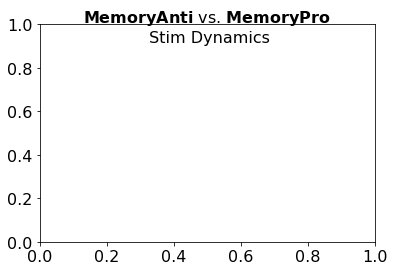

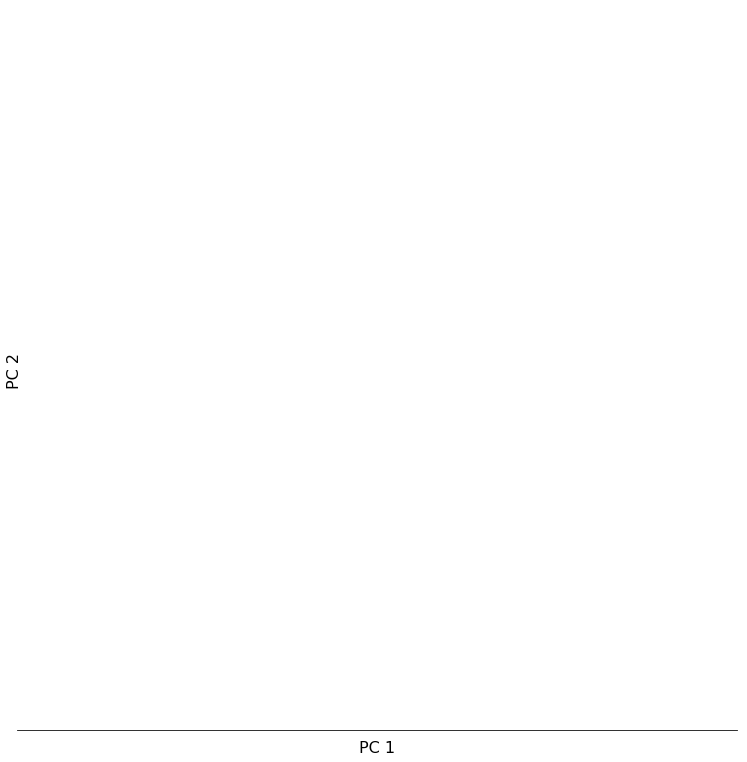

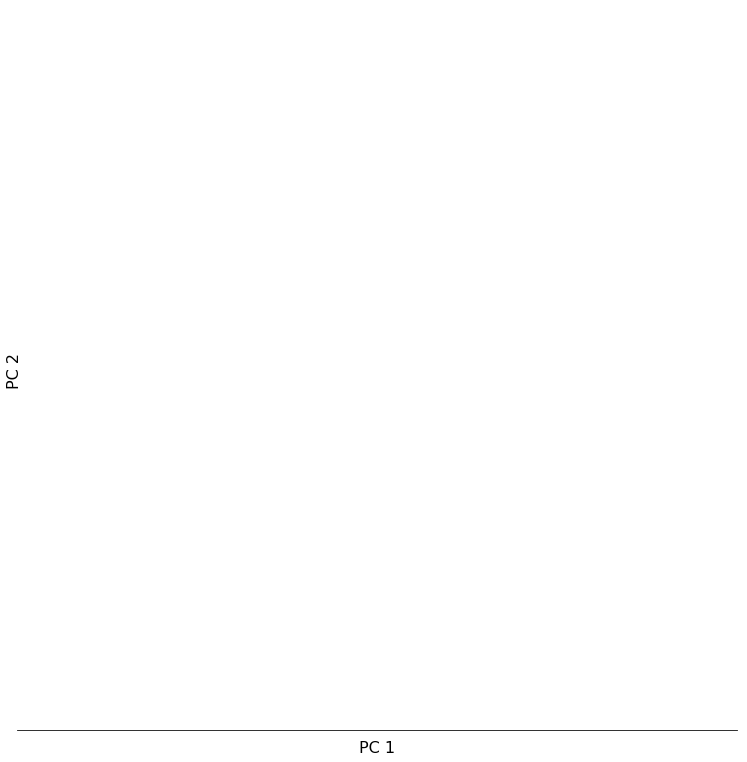

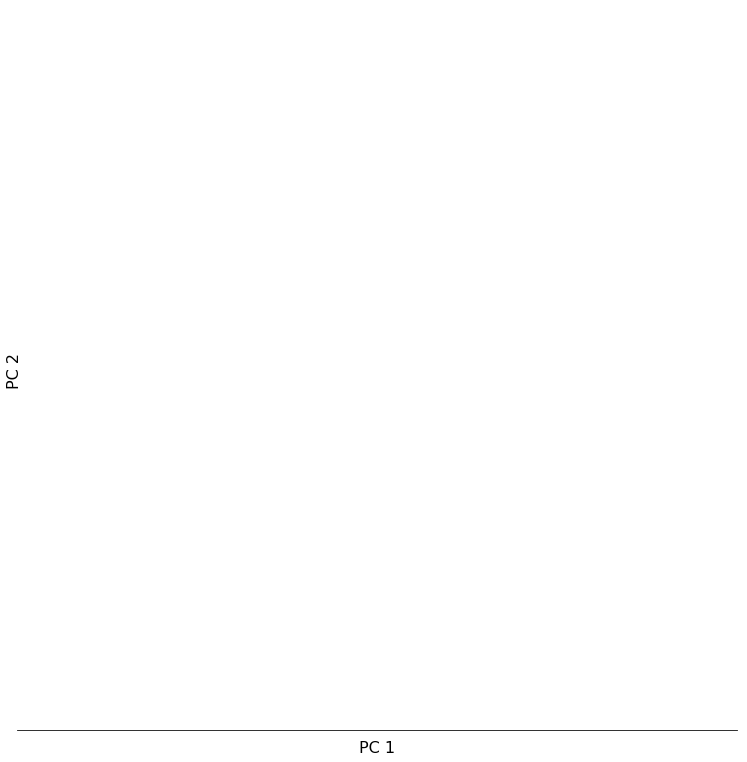

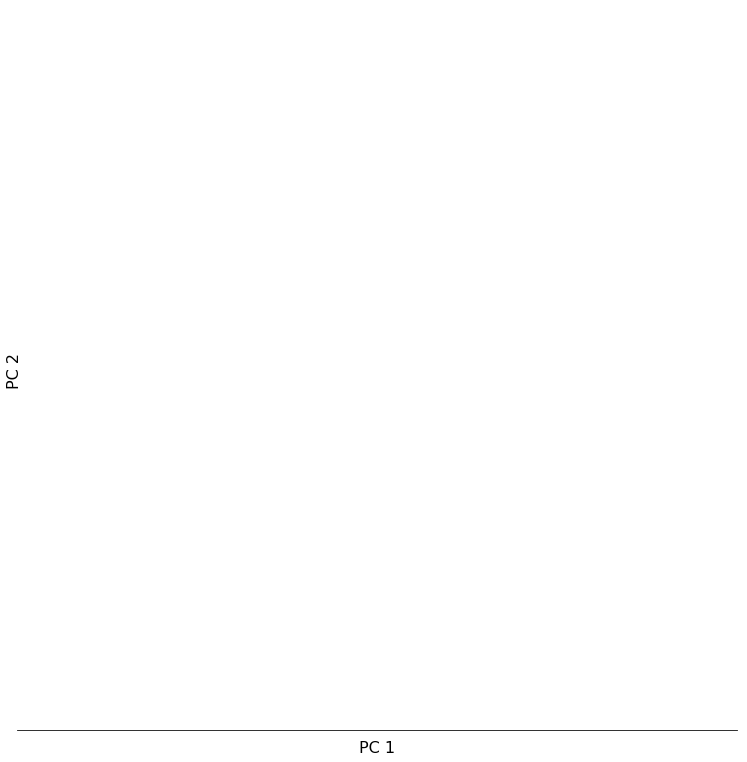

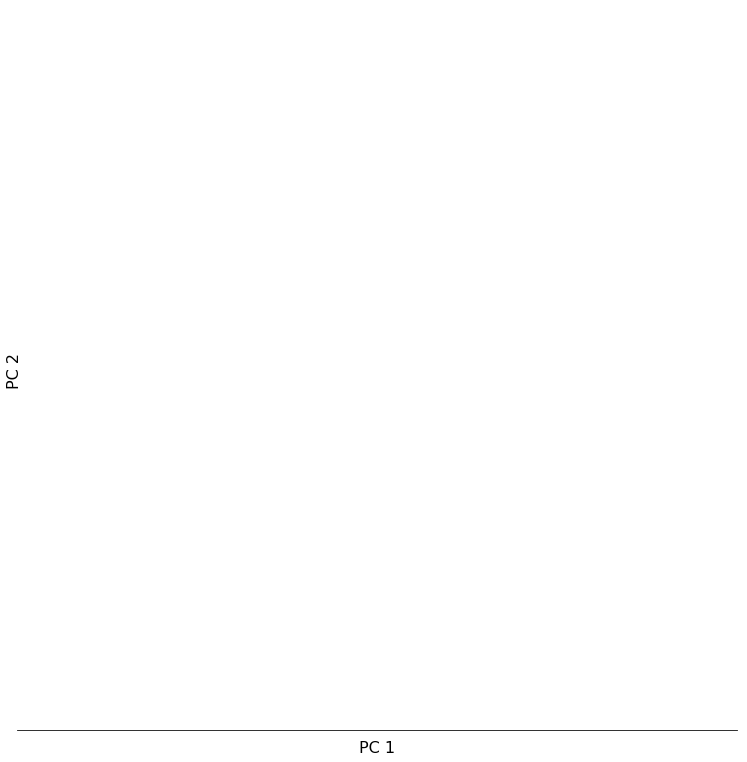

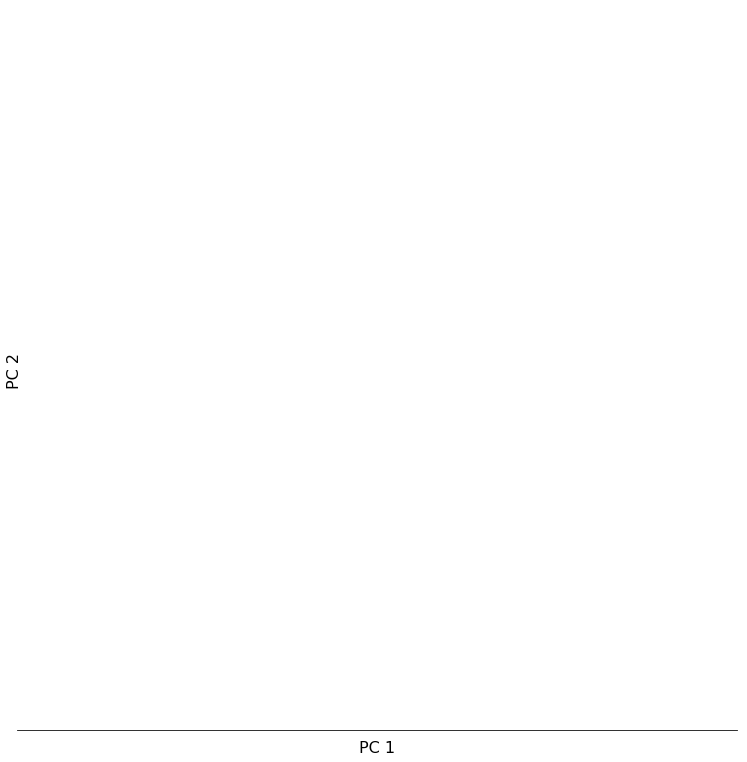

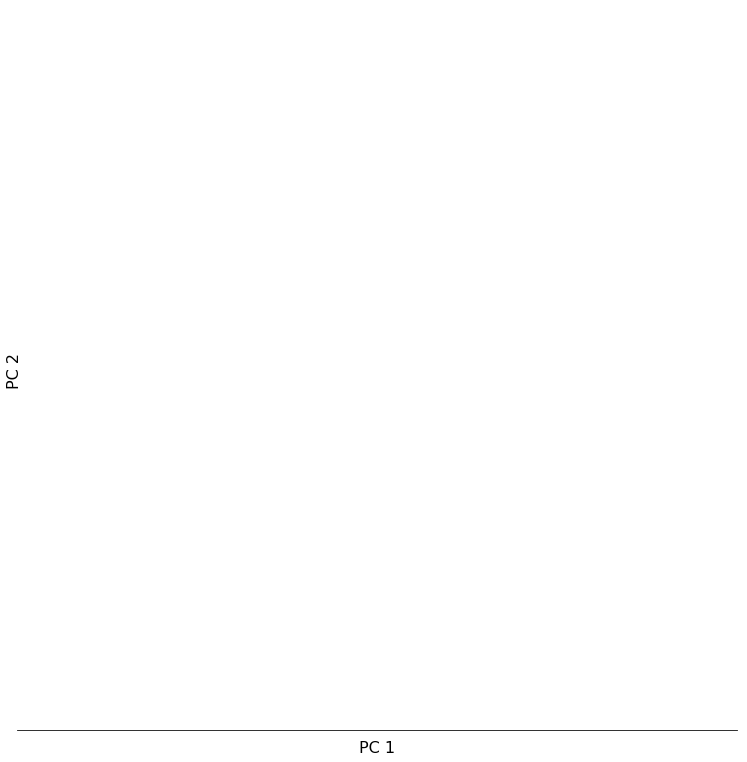

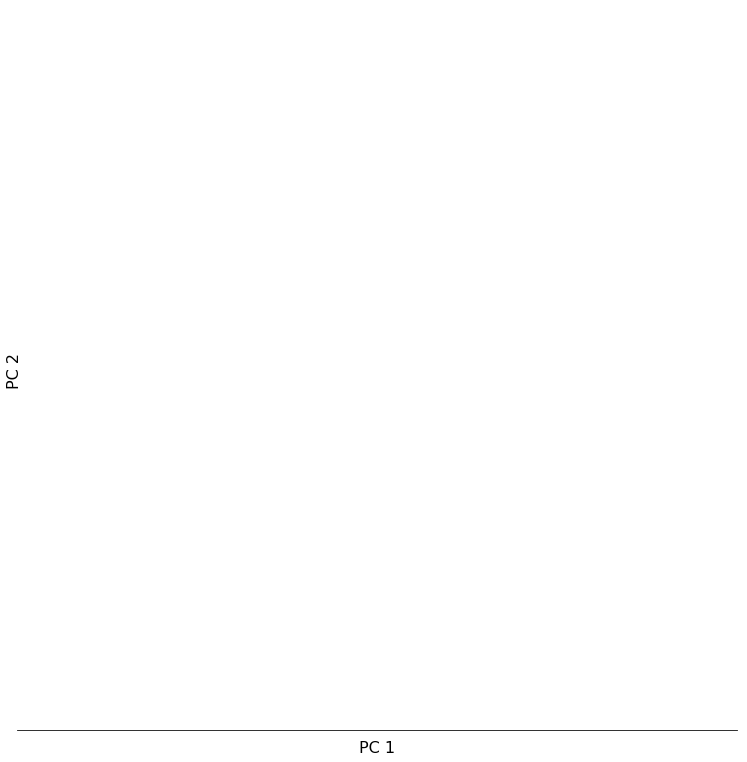

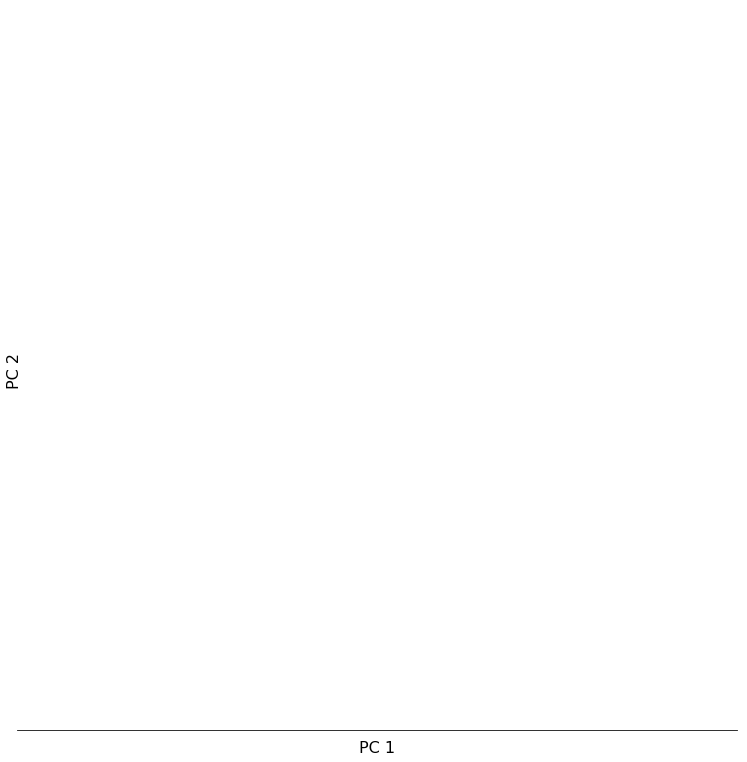

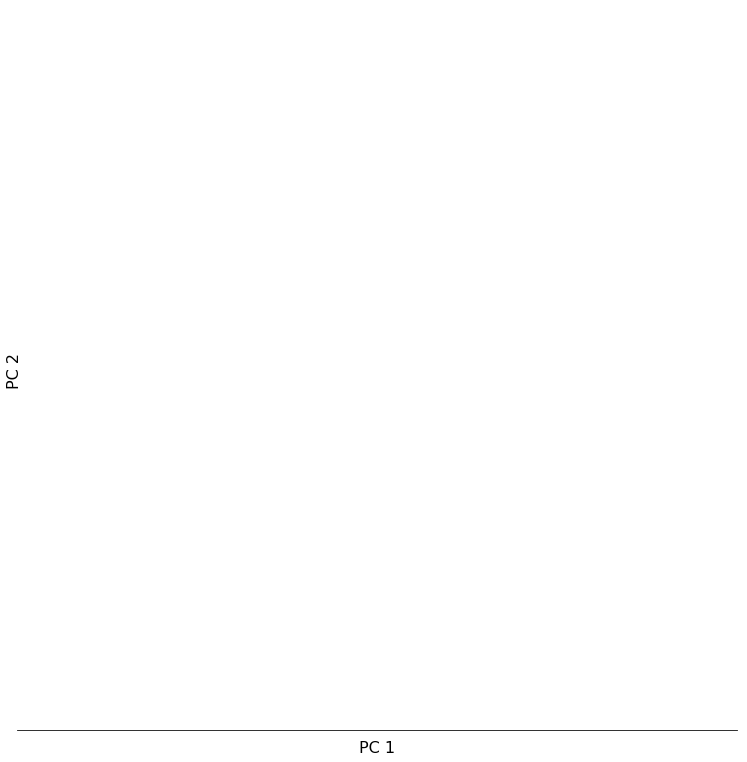

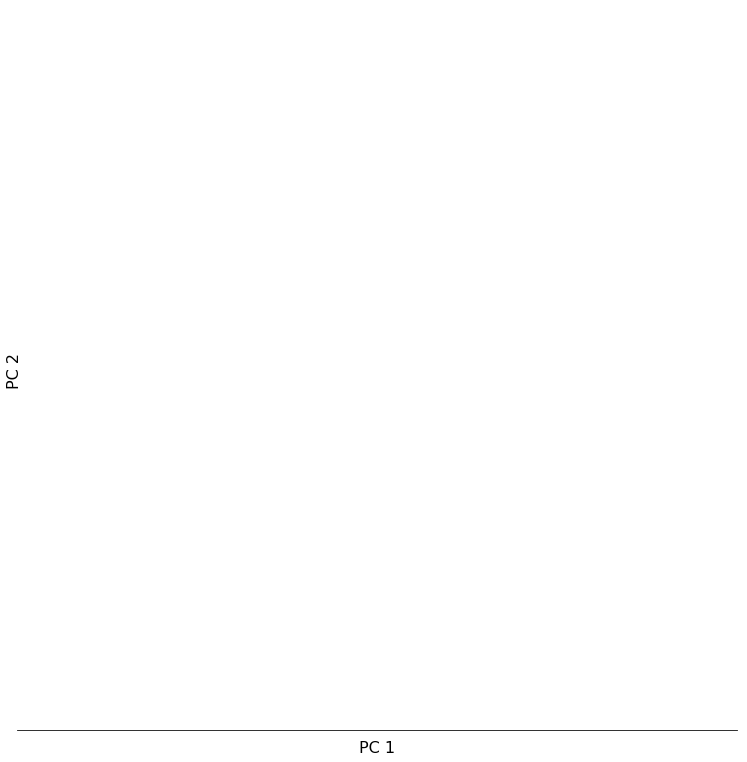

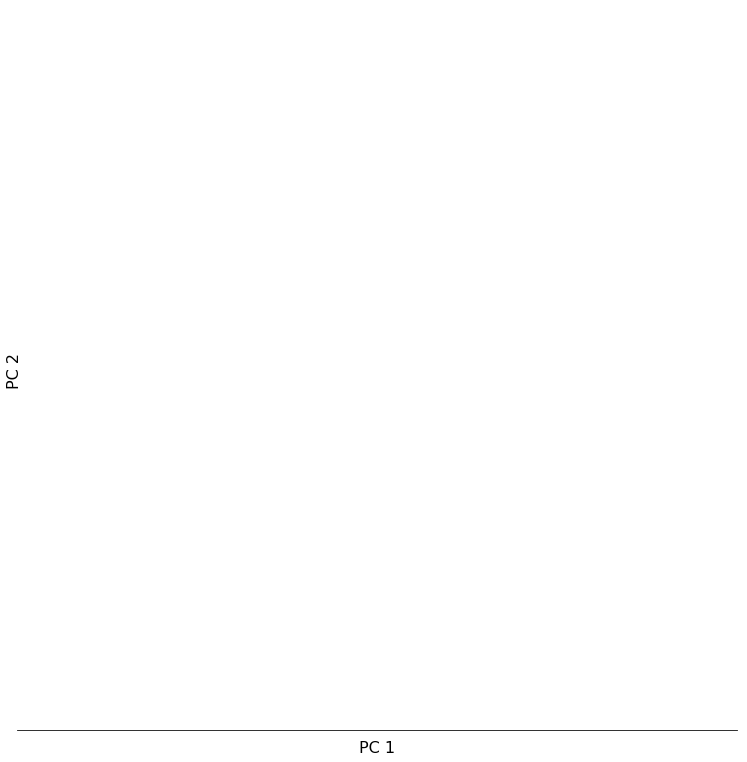

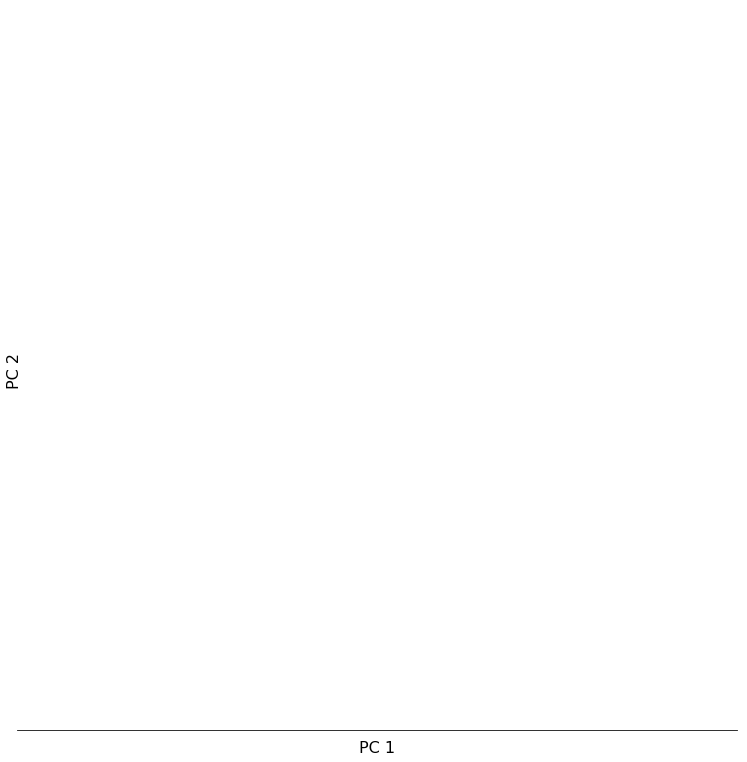

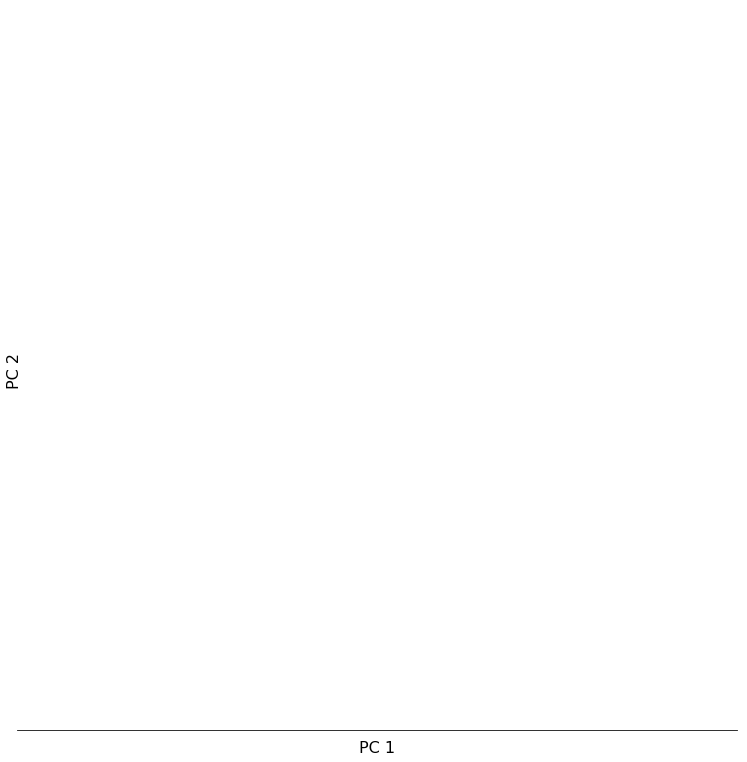

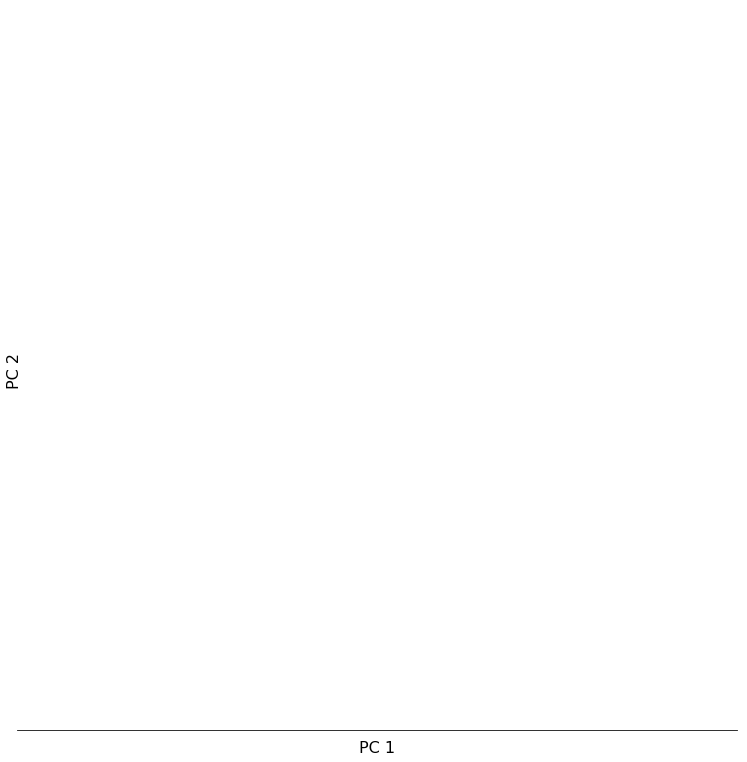

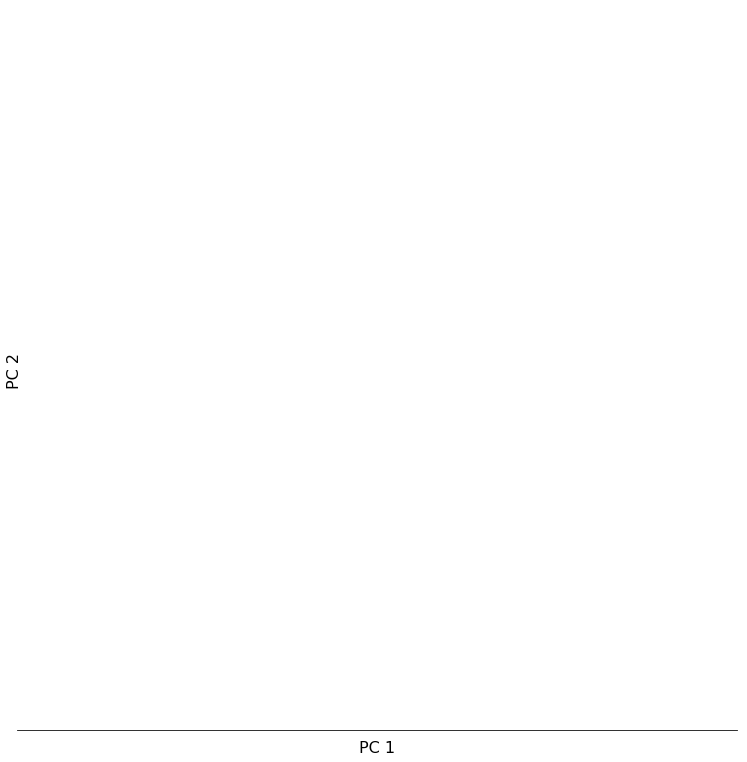

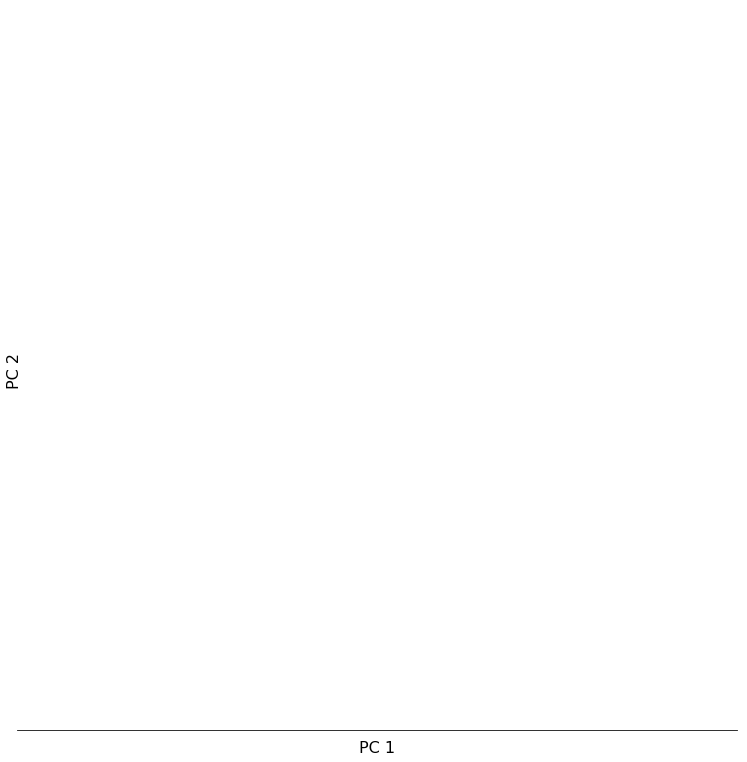

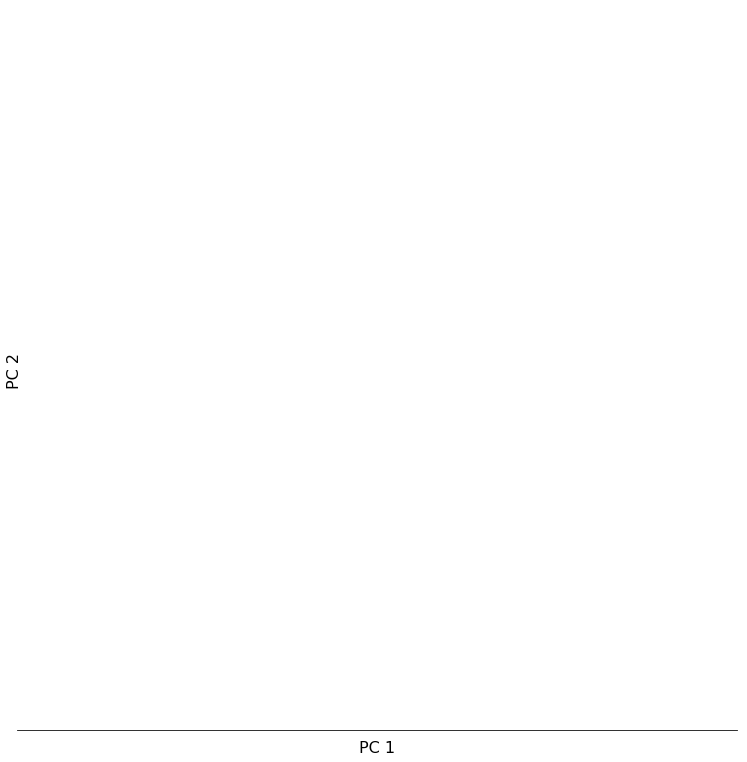

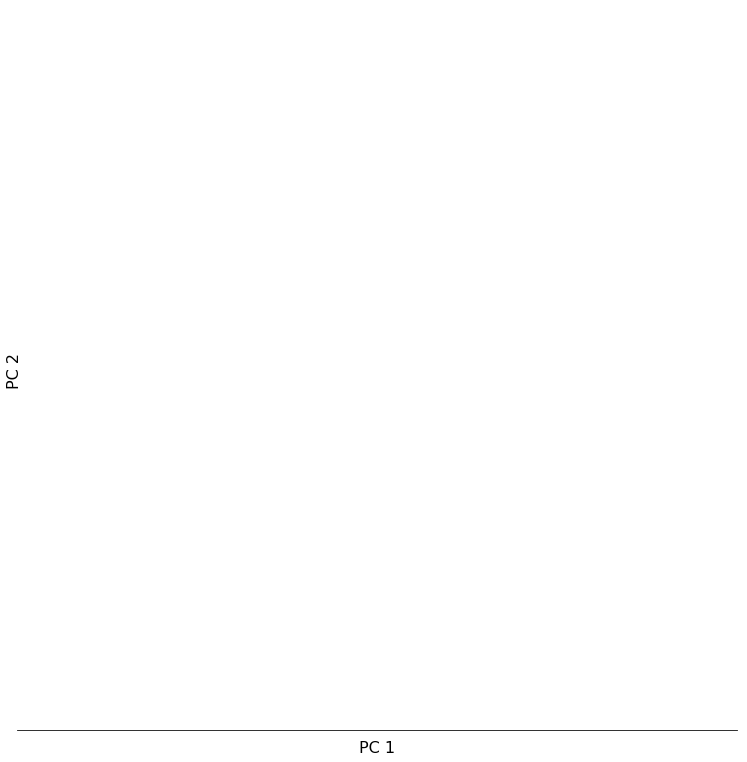

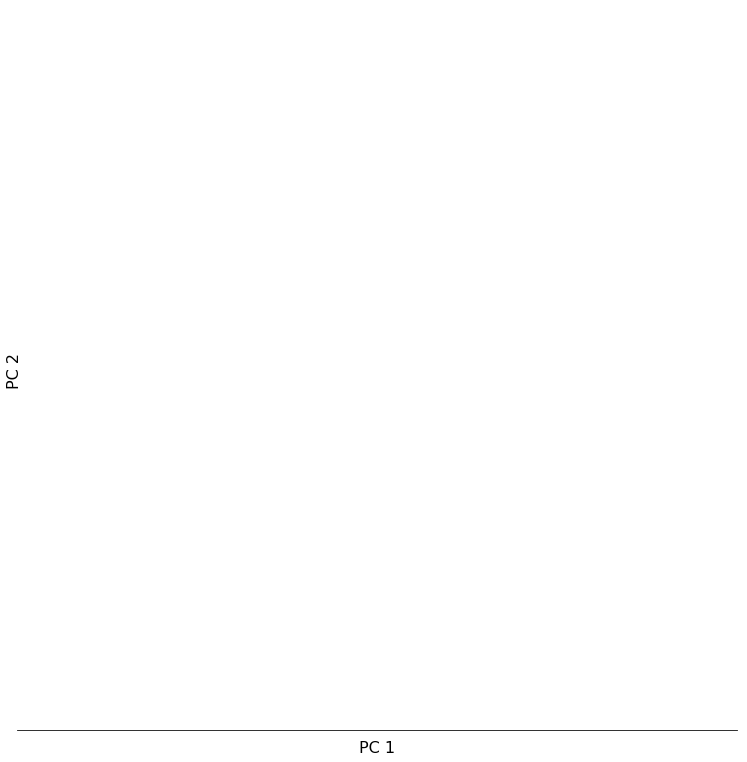

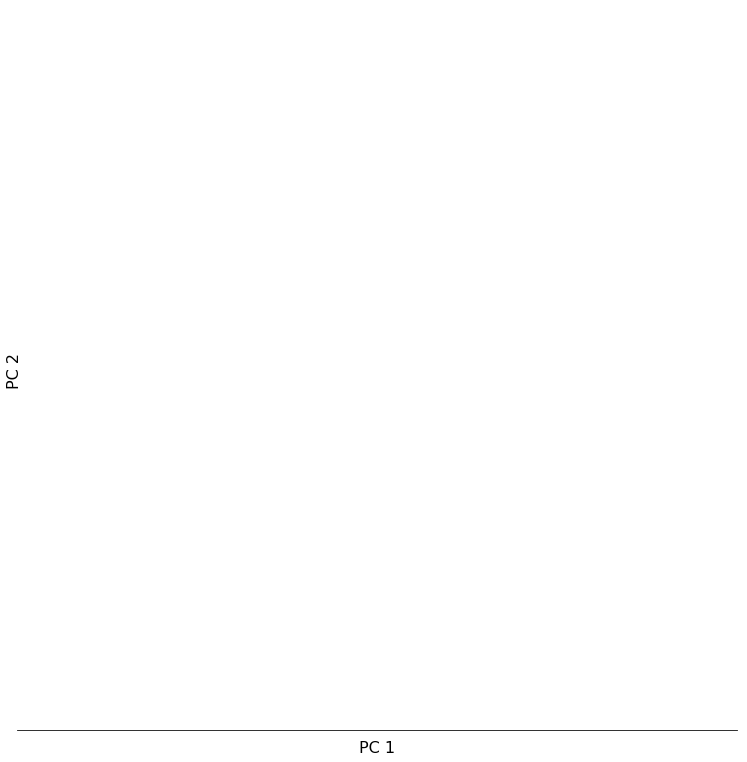

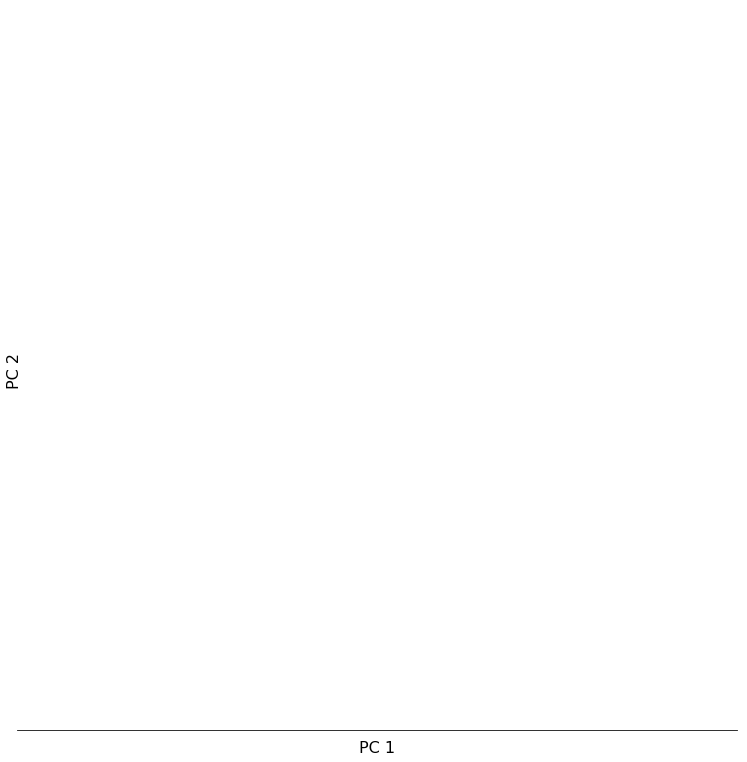

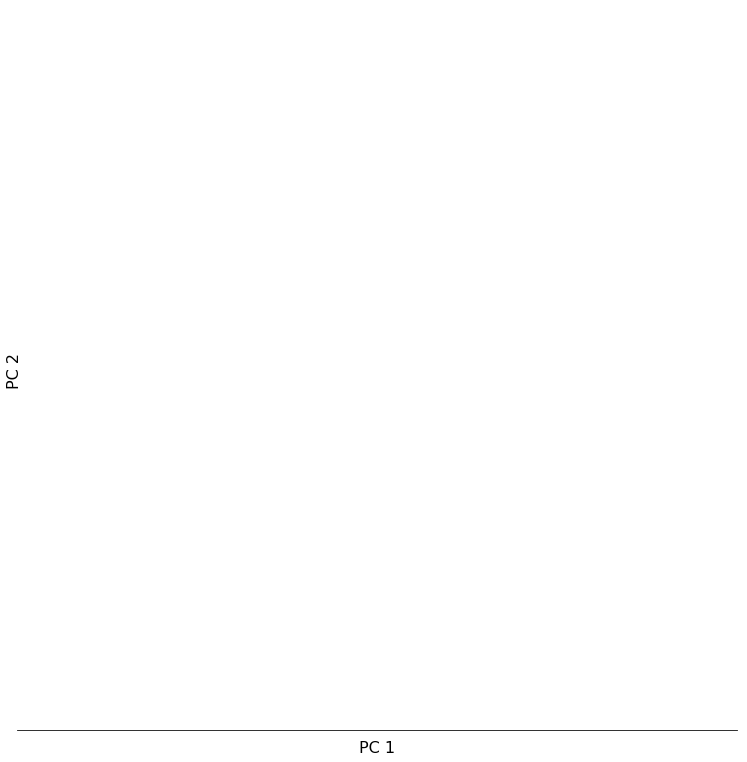

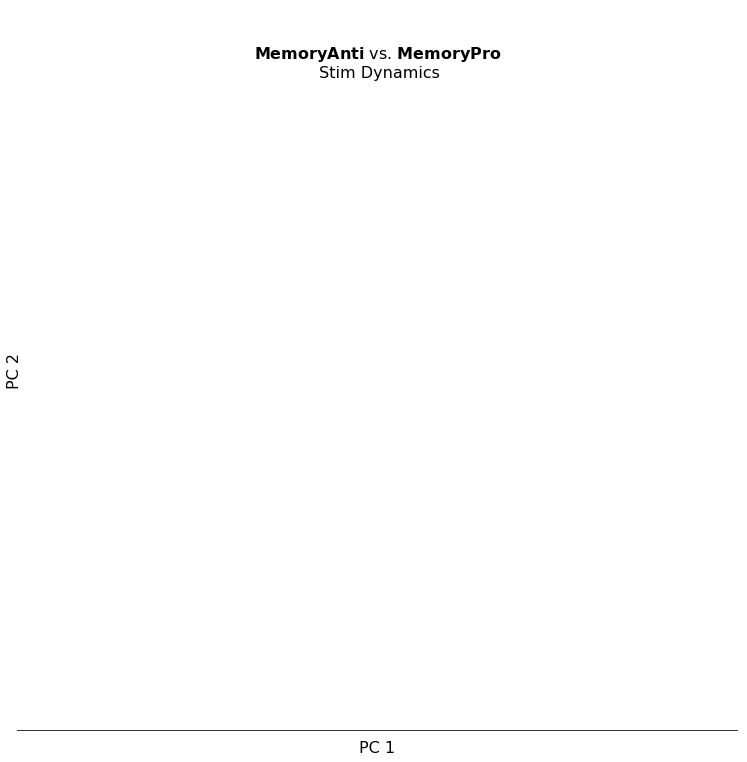

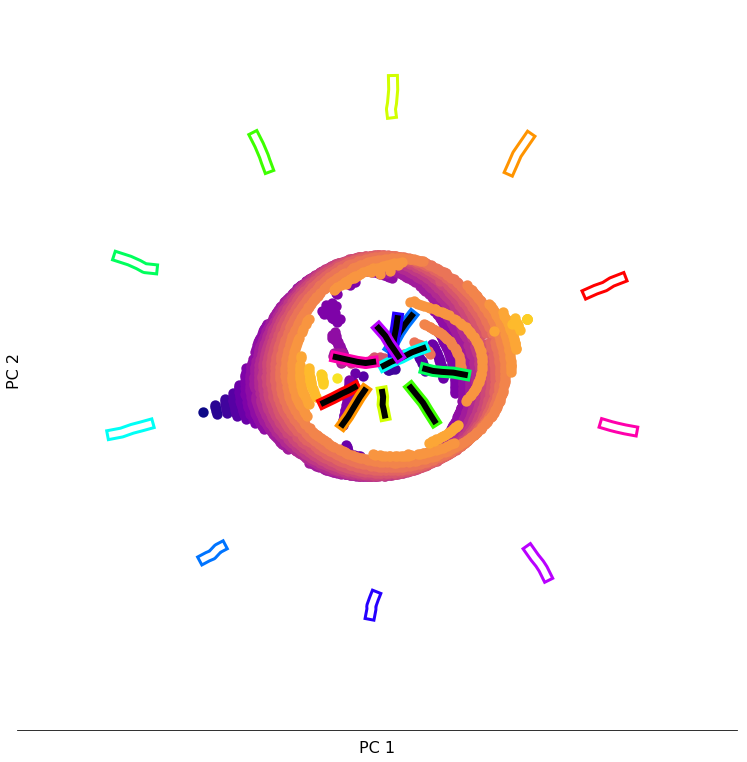

In [33]:
fig_size = 10
epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_mov'

ax_labels = {}
ax_labels[0] = 'PC 1'
ax_labels[1] = 'PC 2'

q_thresh = 1e-7

lim = 1
lims = [-lim,lim,-lim,lim]

lims = bifurc_mov(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,threeD = False,
         n_skip_interps=1,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = lims, view_ang = [31,-52], plot_fps = False, n_trials = 10, bifurc = False)

lims = bifurc_mov(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,threeD = False,
         n_skip_interps=1,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = lims, view_ang = [31,-52], plot_fps = True, n_trials = 10, bifurc = False)

In [ ]:
fig_size = 10
epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'

ax_labels = {}
ax_labels[0] = 'PC 1'
ax_labels[1] = 'PC 2'

q_thresh = 1e-7

lim = 1
lims = [-lim,lim,-lim,lim]

lims = bifurc_mov(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,threeD = False,
         n_skip_interps=1,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = lims, view_ang = [31,-52], plot_fps = False, n_trials = 10, bifurc = False)

lims = bifurc_mov(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,threeD = False,
         n_skip_interps=1,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = lims, view_ang = [31,-52], plot_fps = True, n_trials = 10, bifurc = False)

In [8]:
rule_set = [2,11]
# rule_set = [5,2]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) 

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multi

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) 

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multi

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) 

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multi

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multi

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) 

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/interp_tasks_small_init_mov/delaygo_delaygo/tol_q_e_6.0/delaygo_delaygo_delay1_delay1_x0.0_x0.0_step_0.npz'

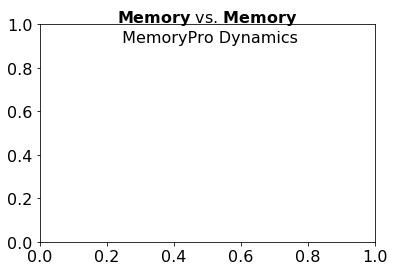

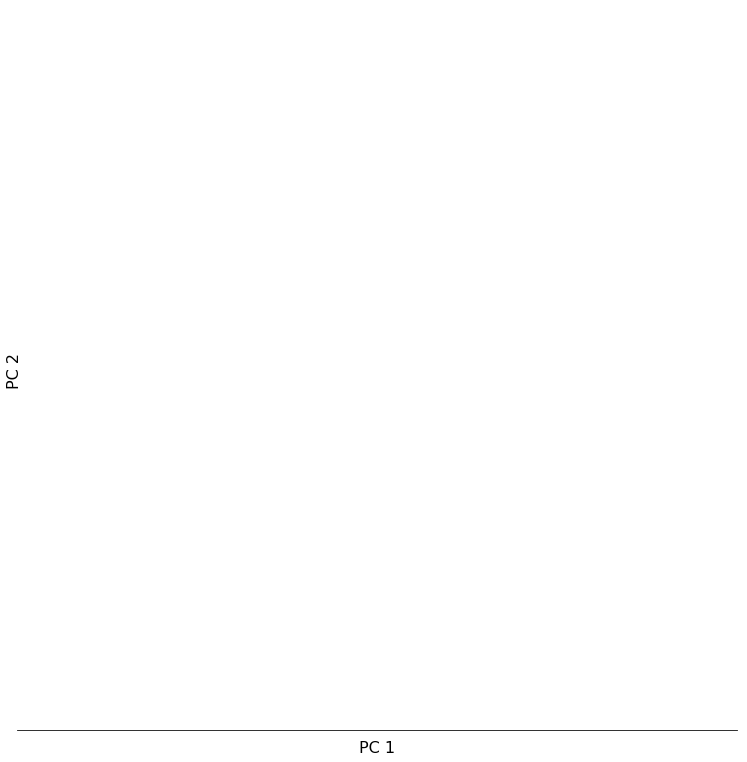

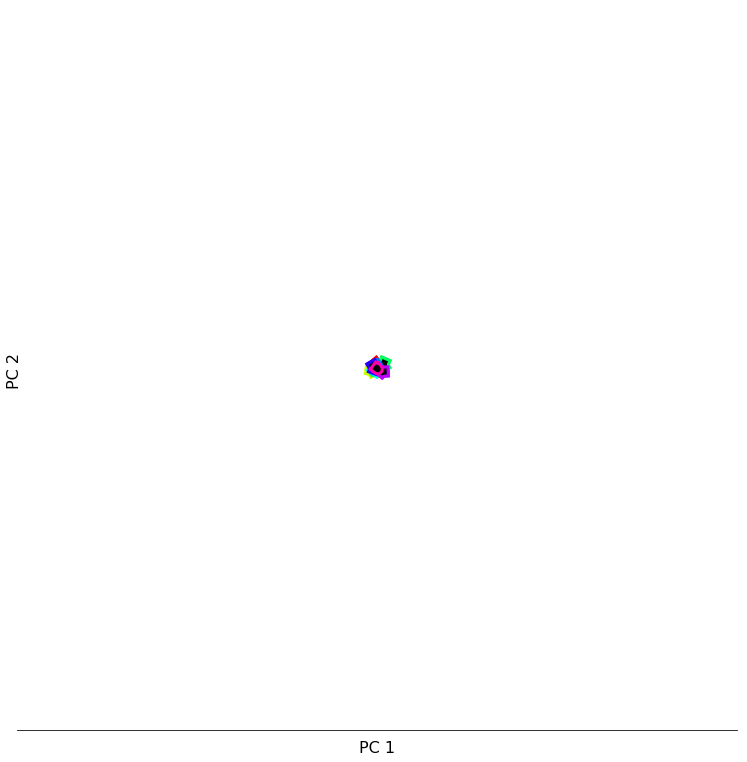

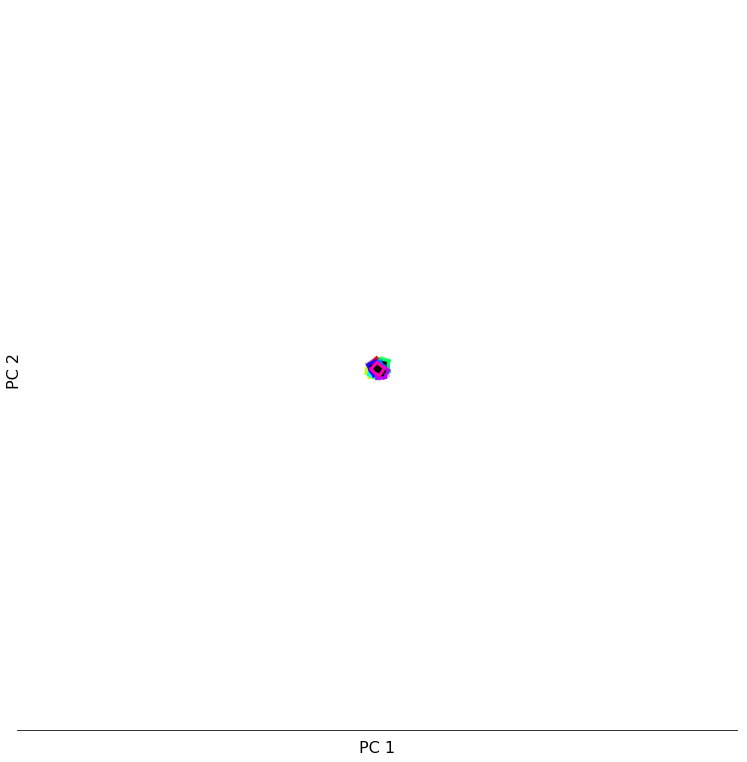

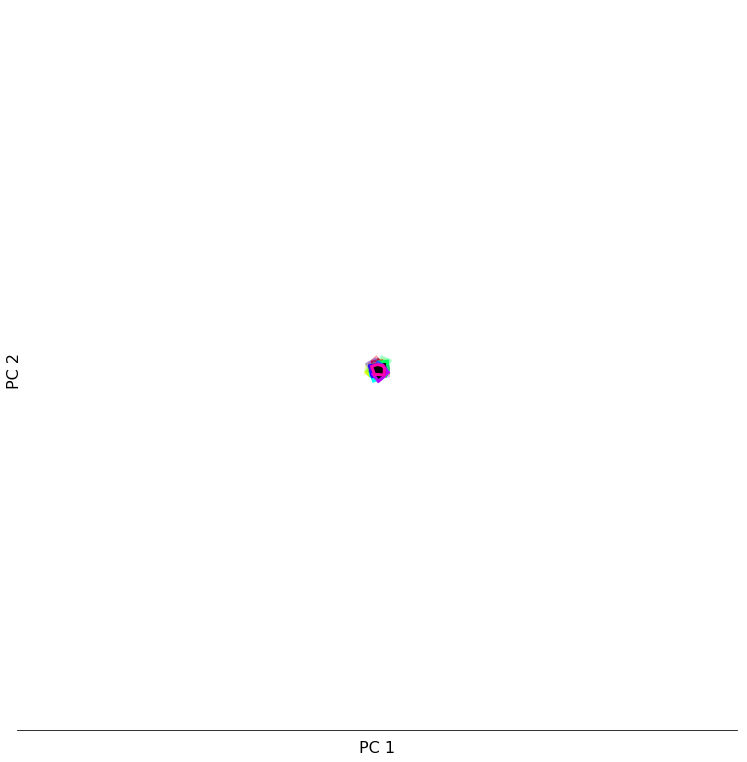

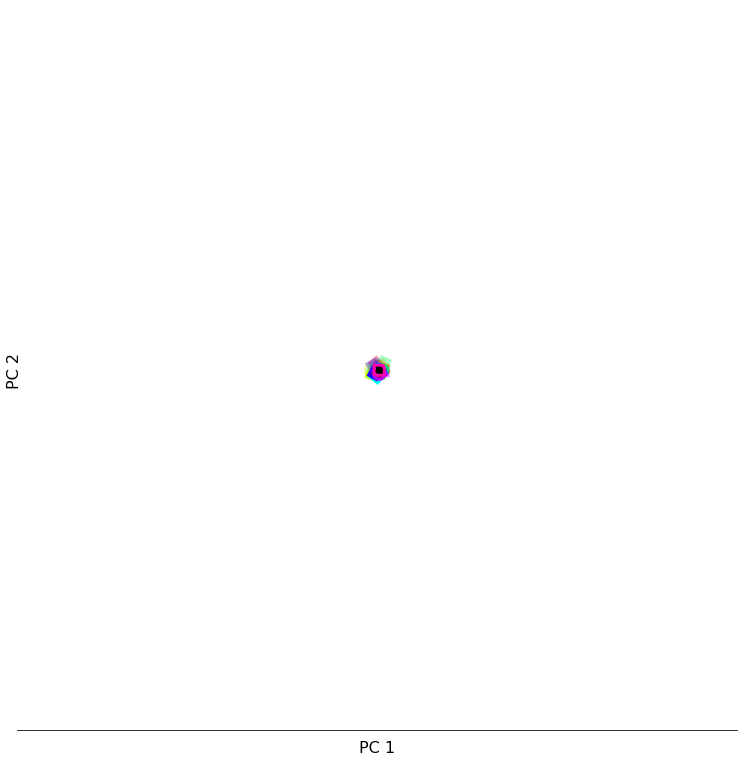

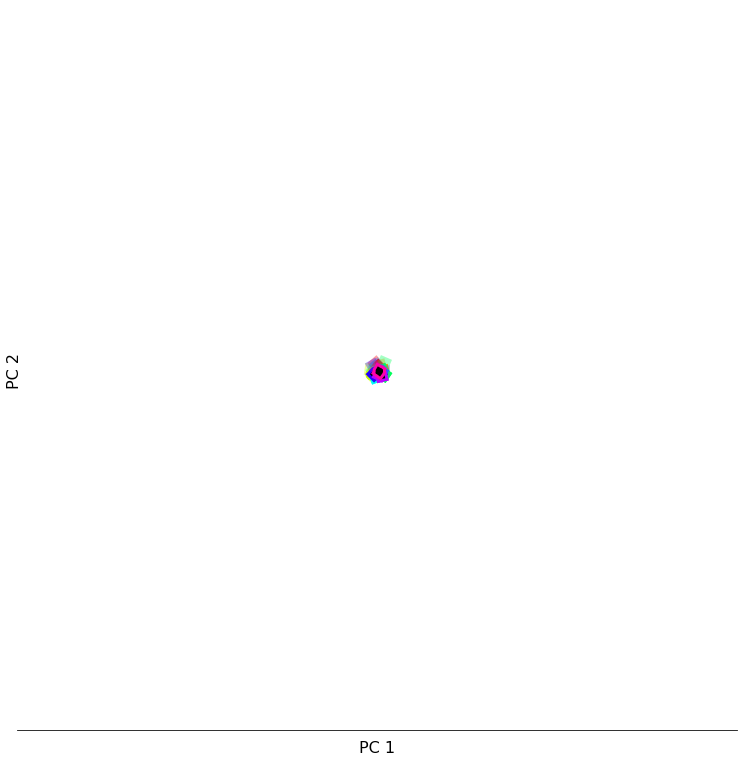

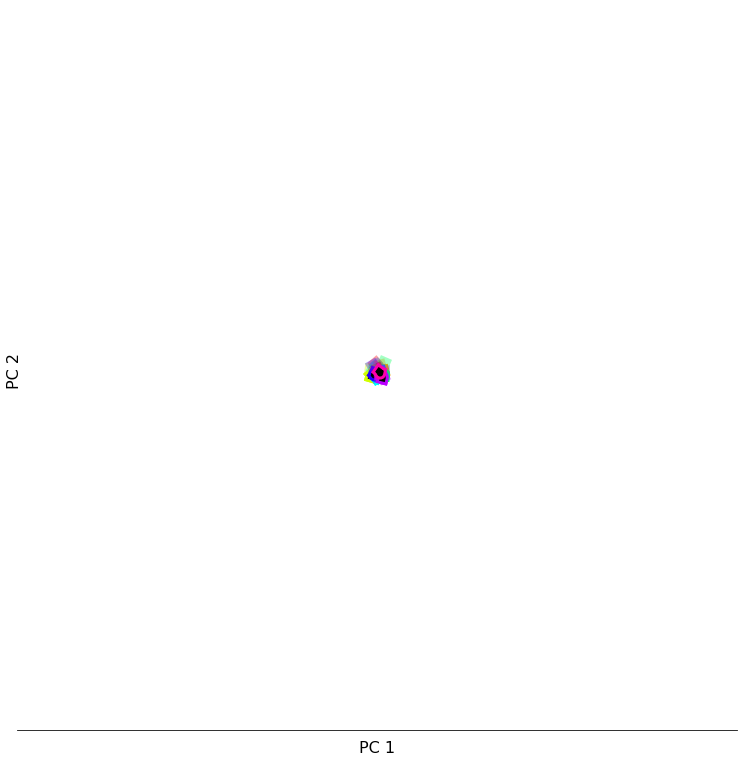

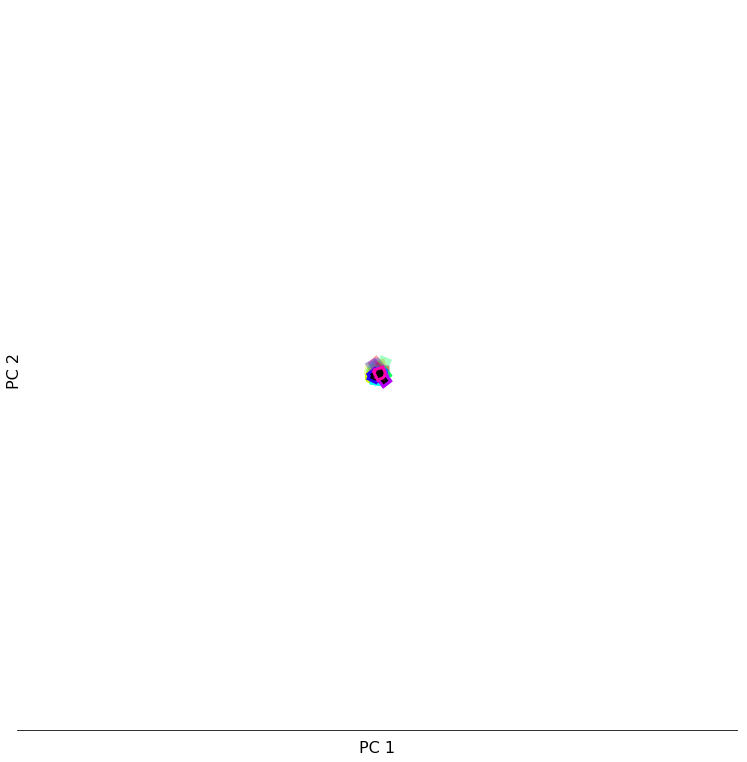

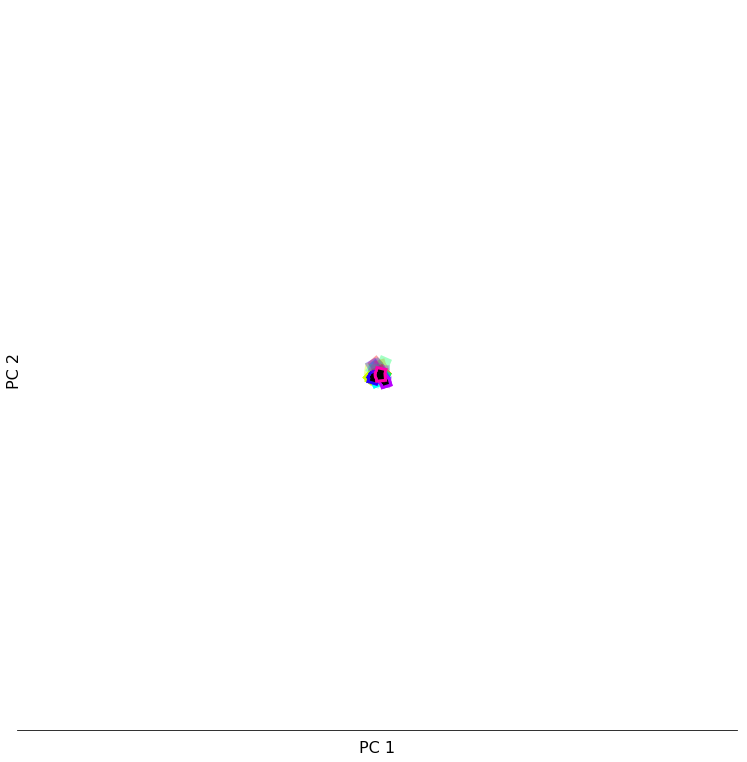

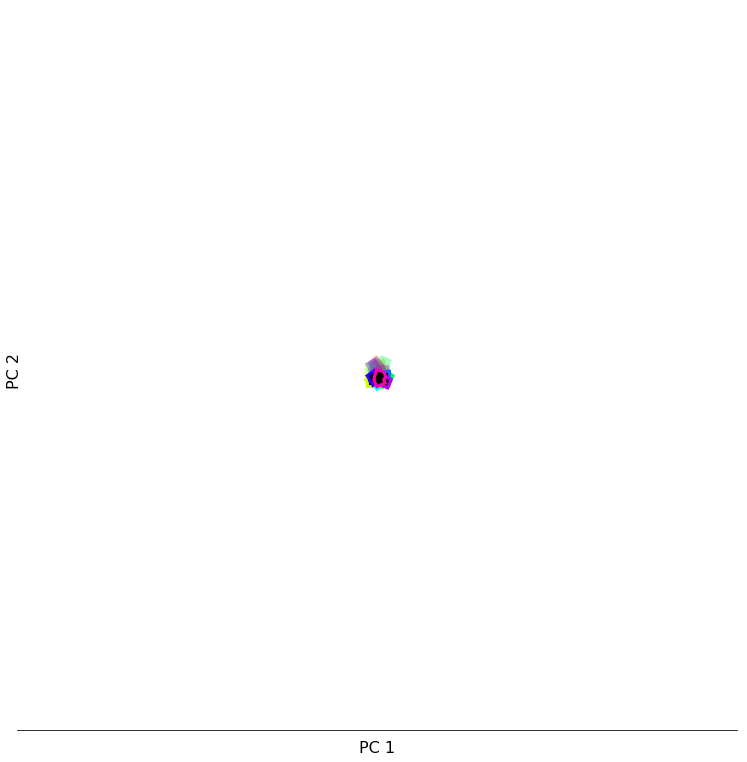

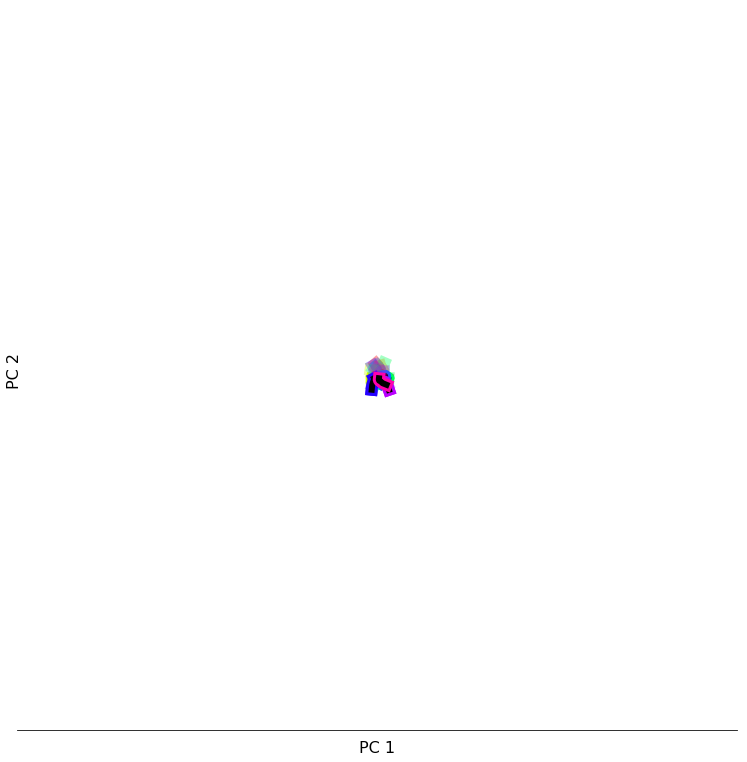

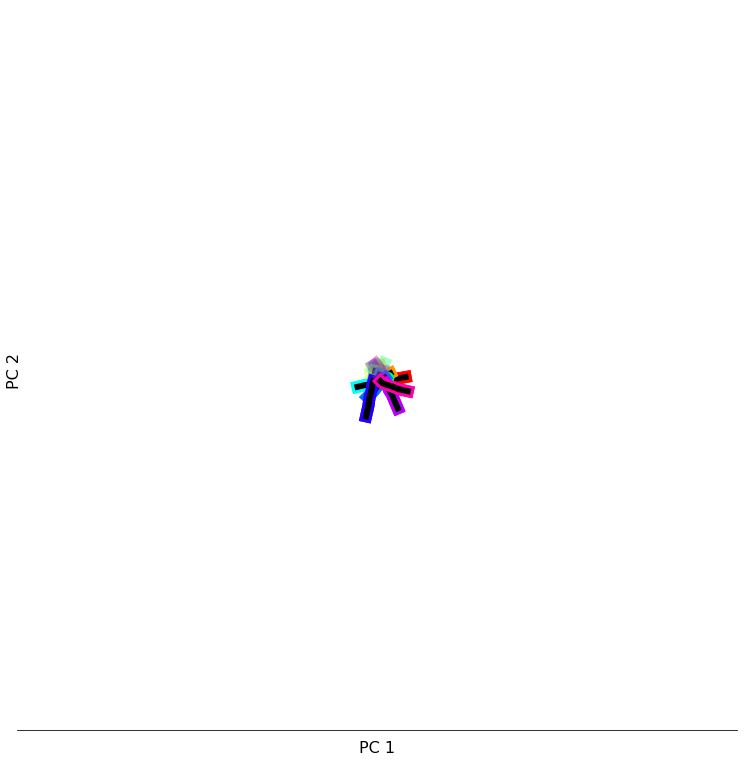

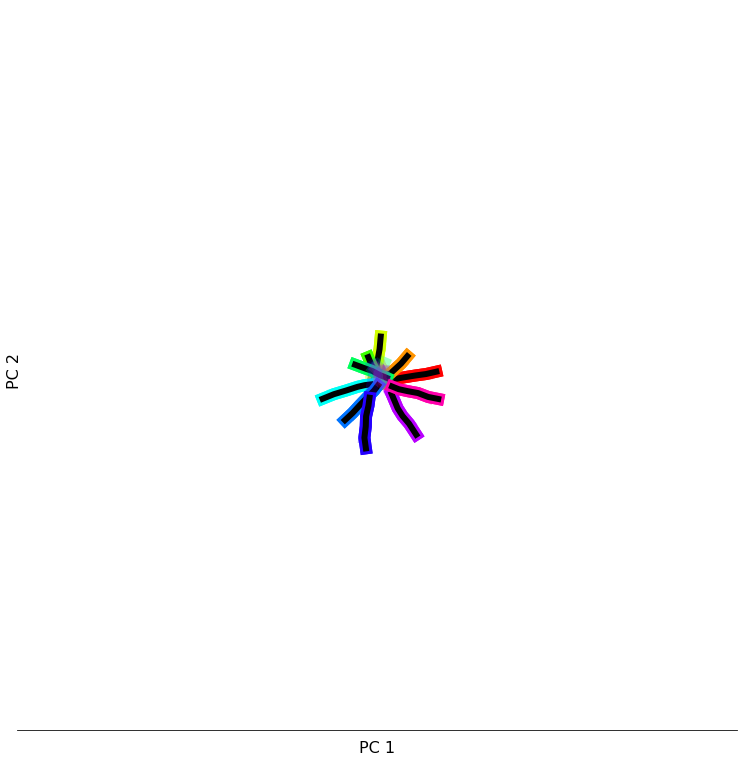

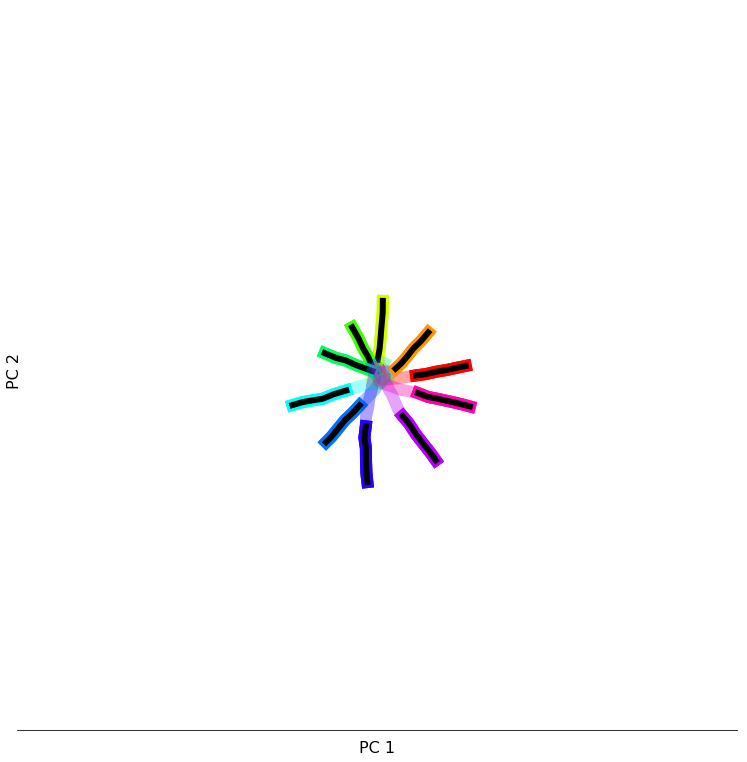

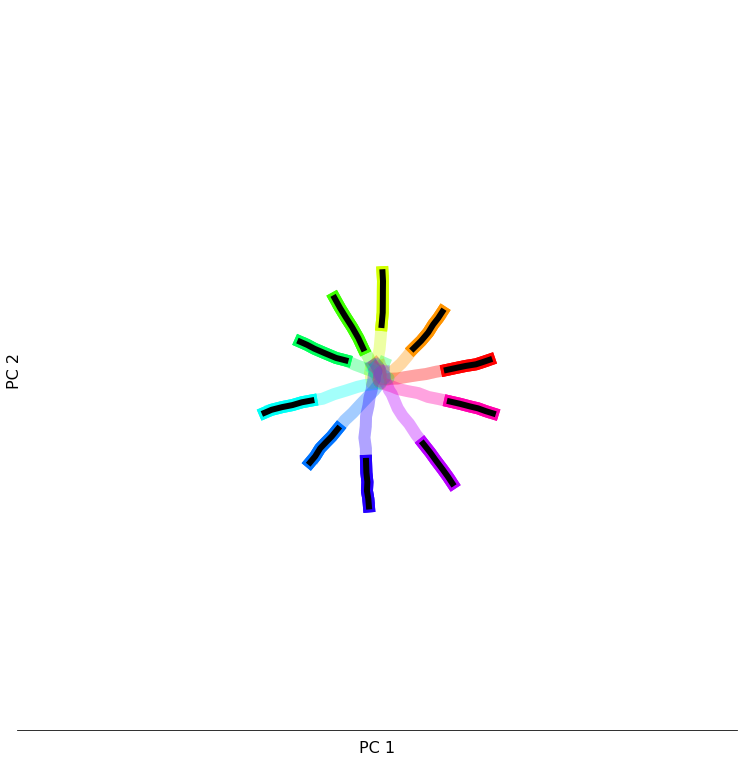

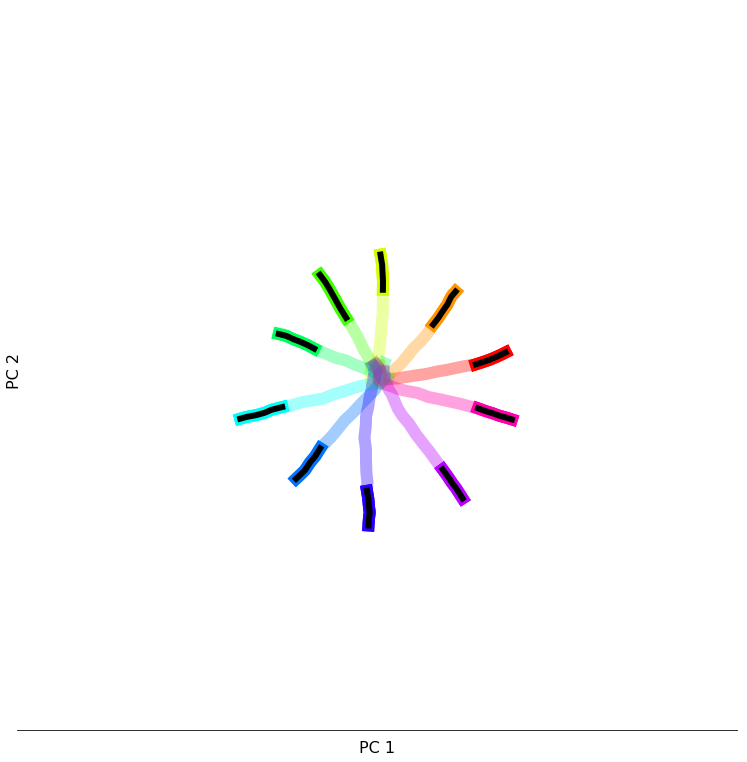

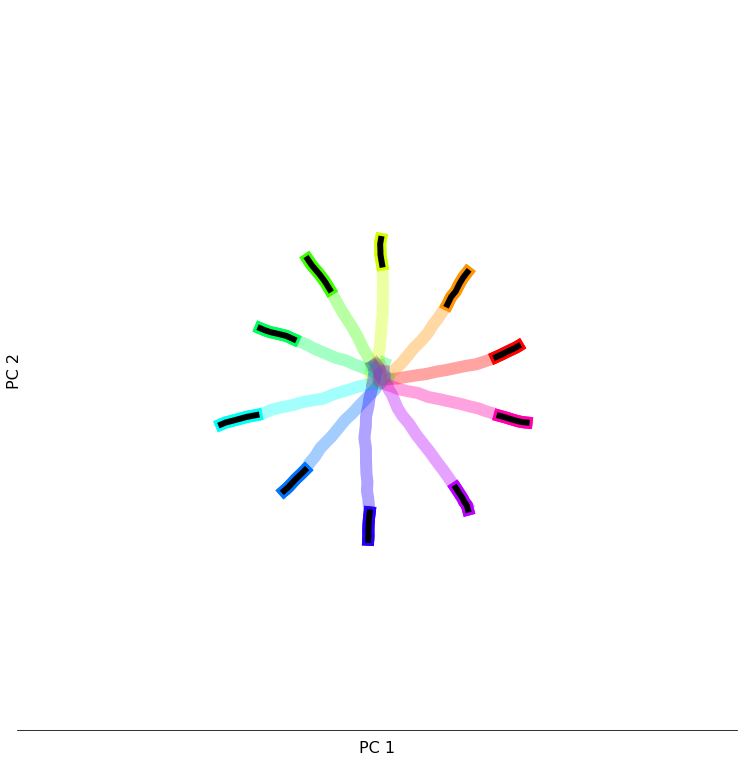

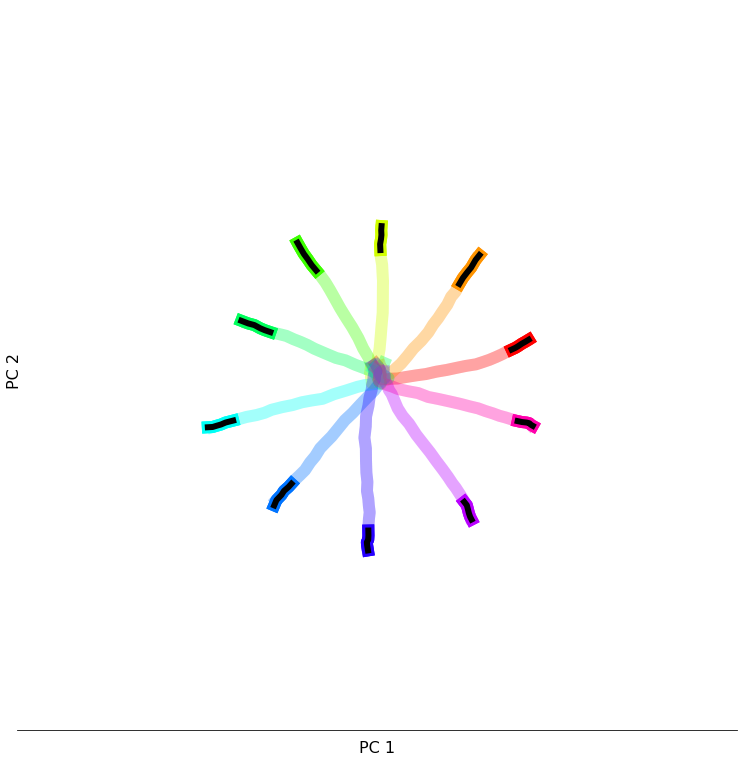

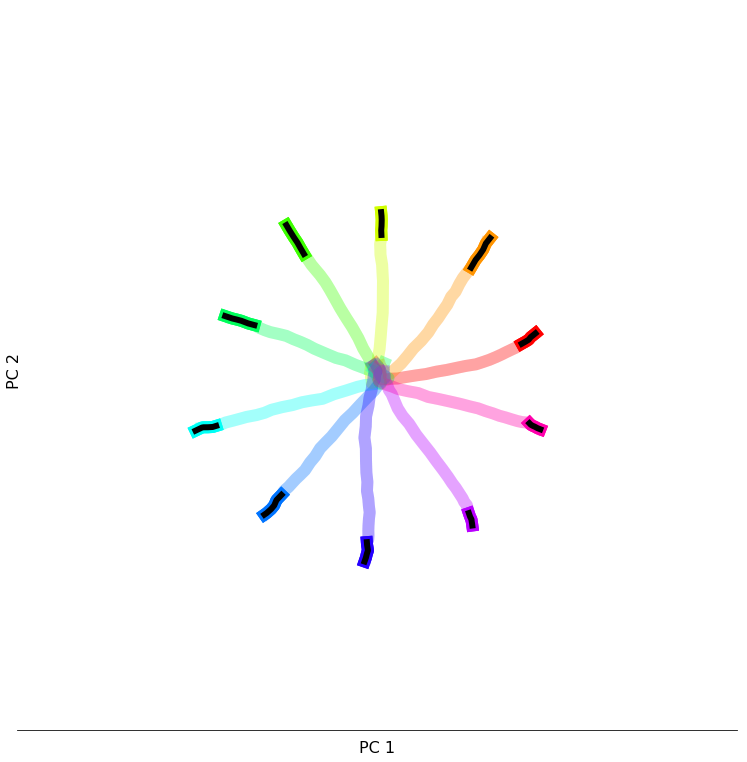

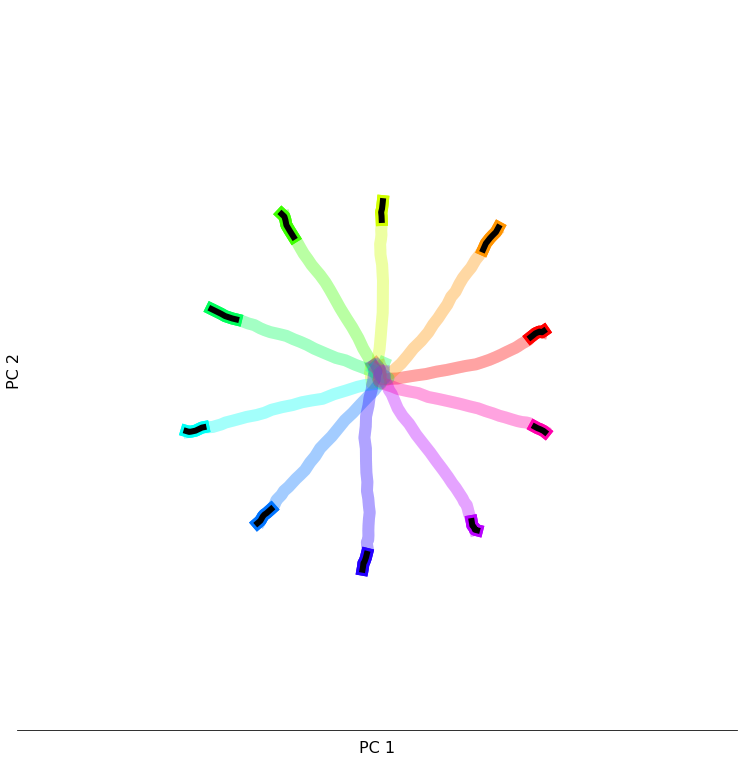

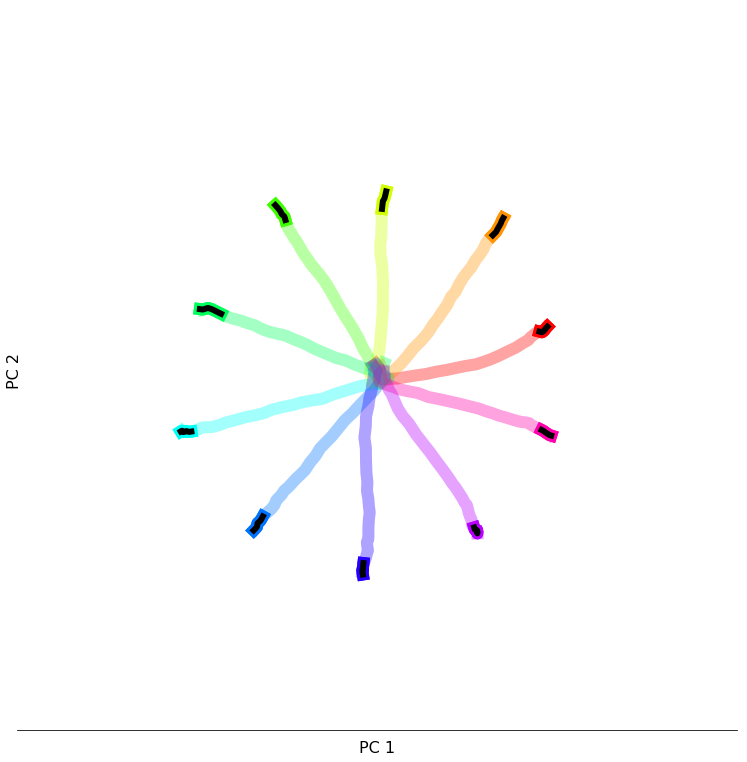

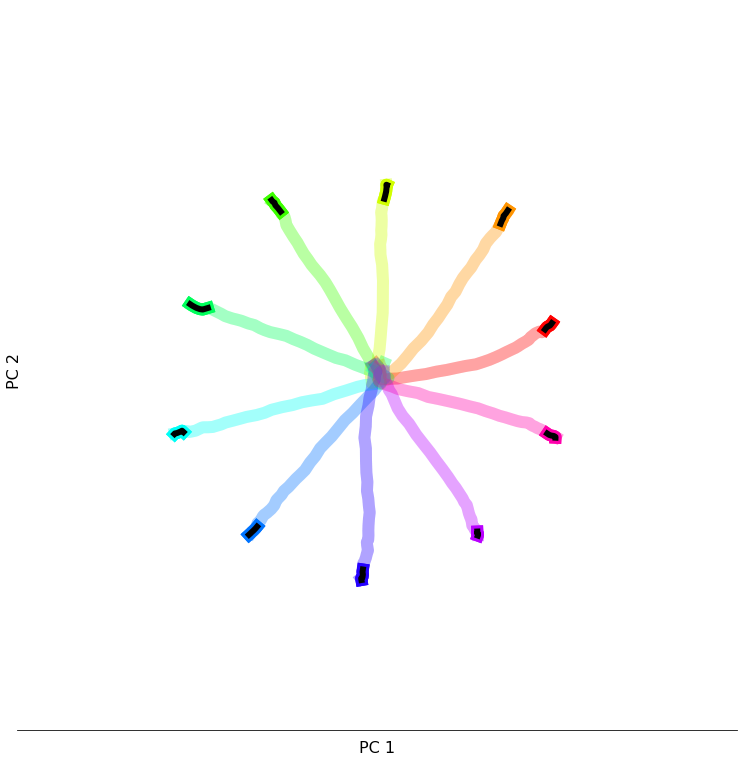

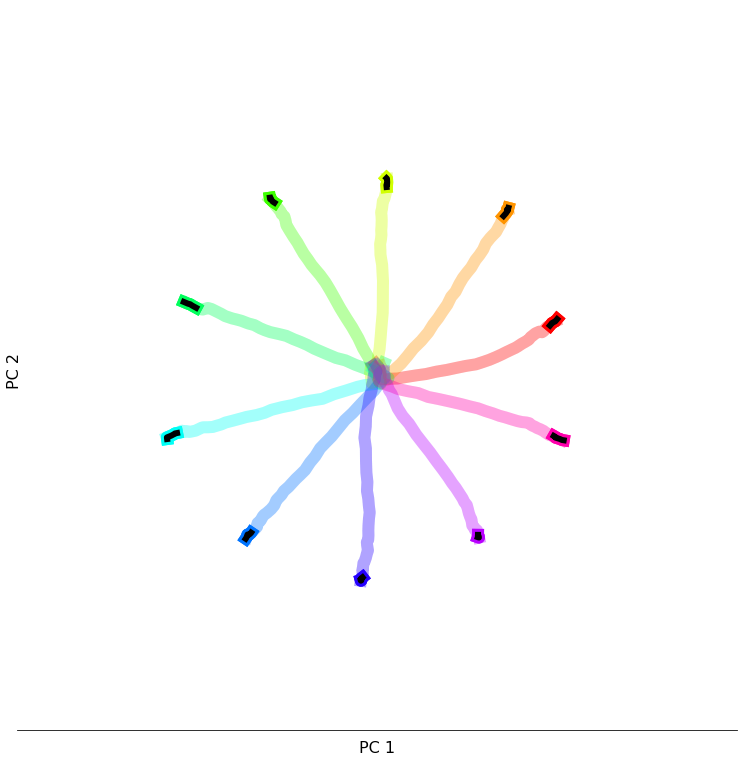

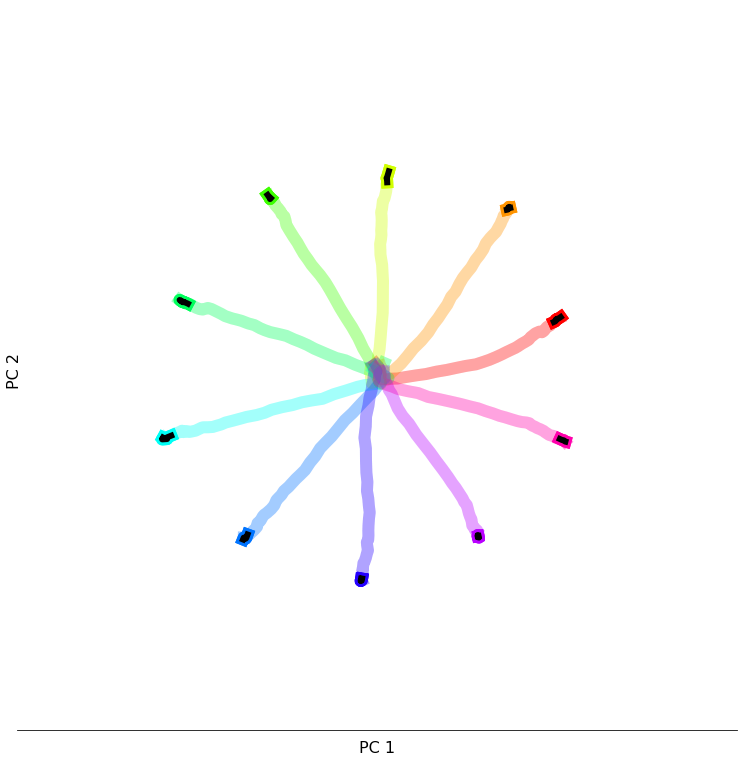

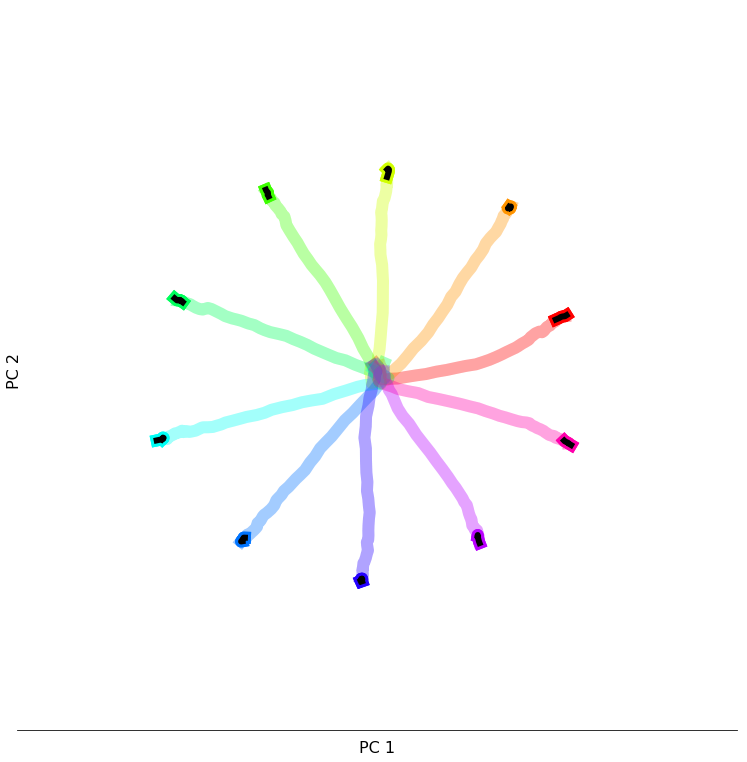

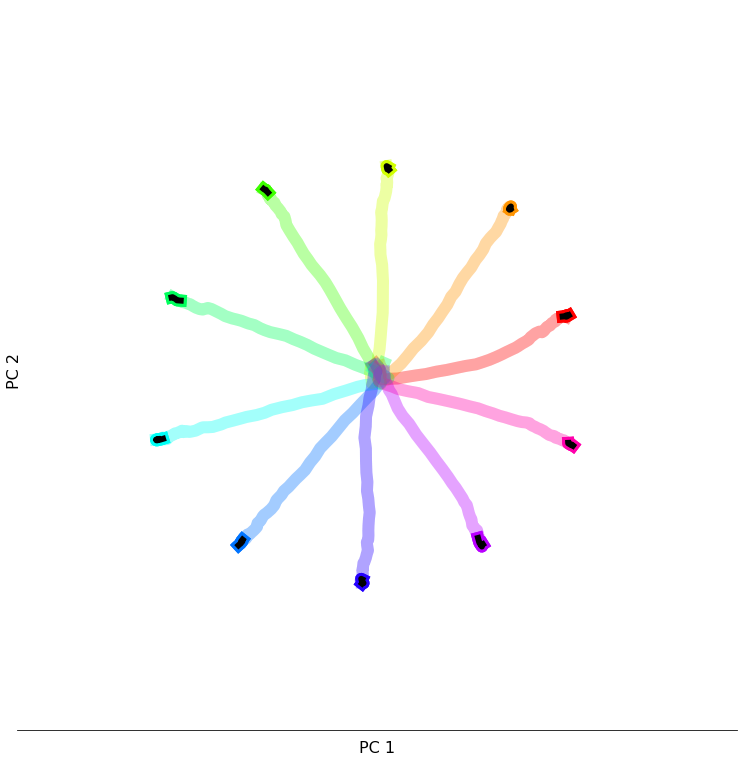

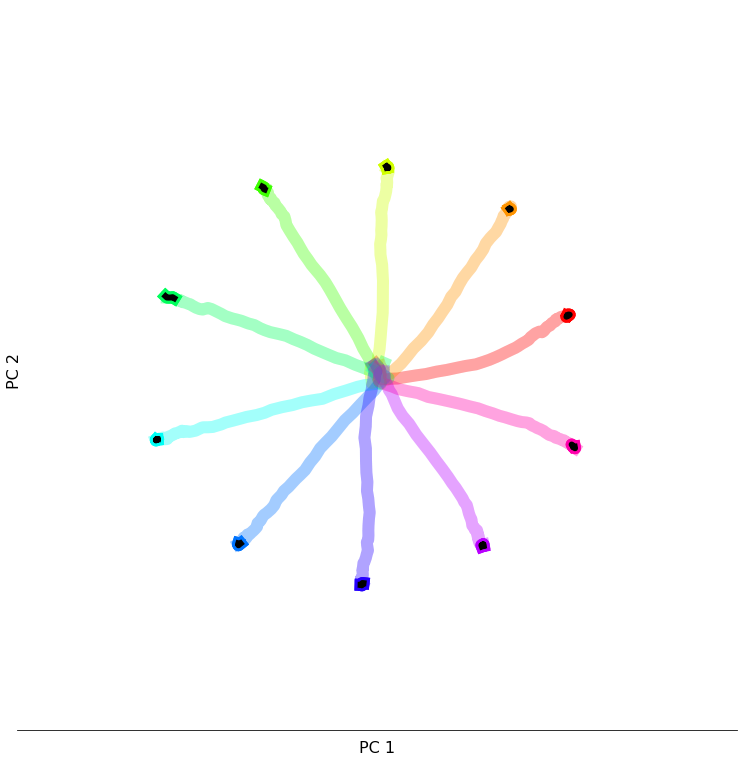

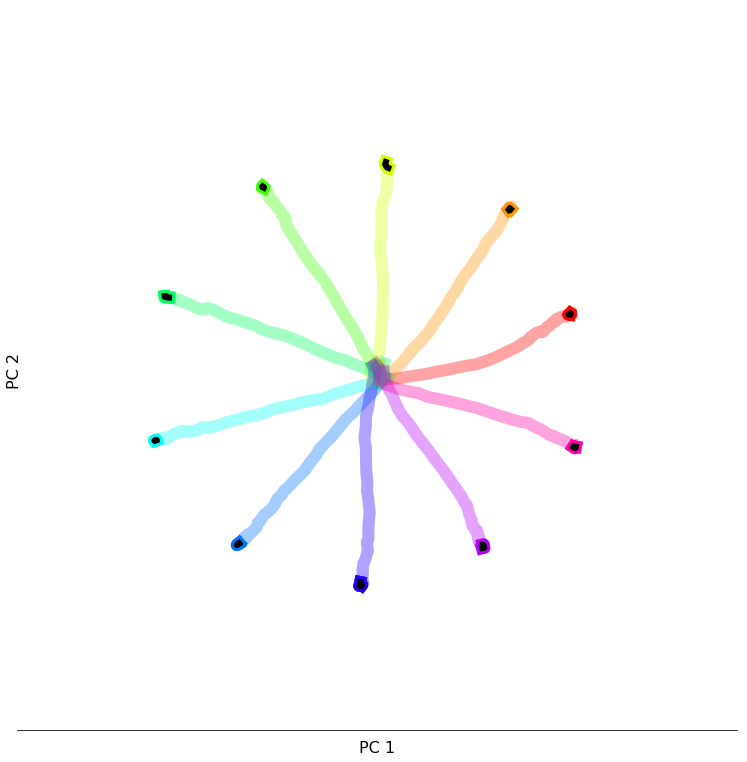

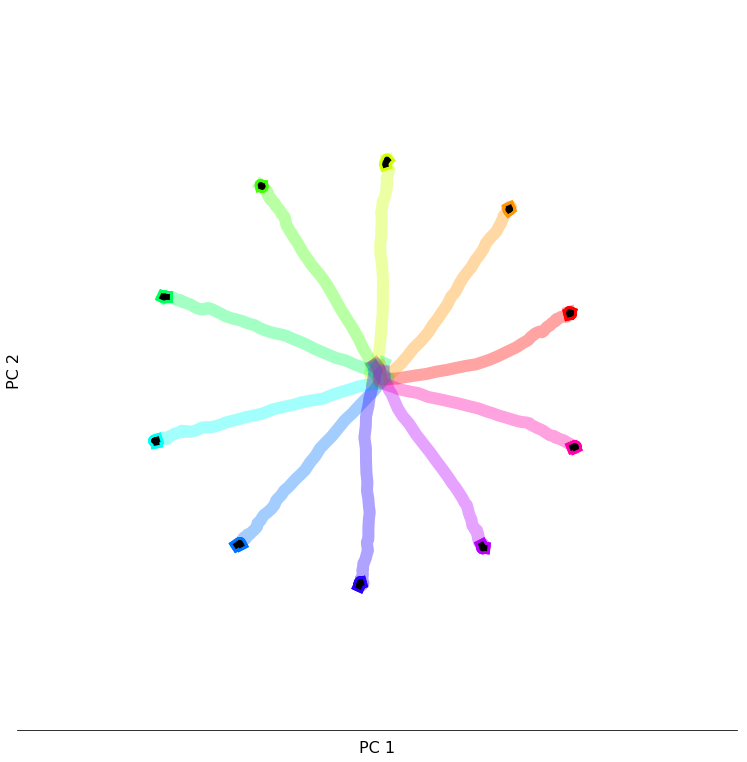

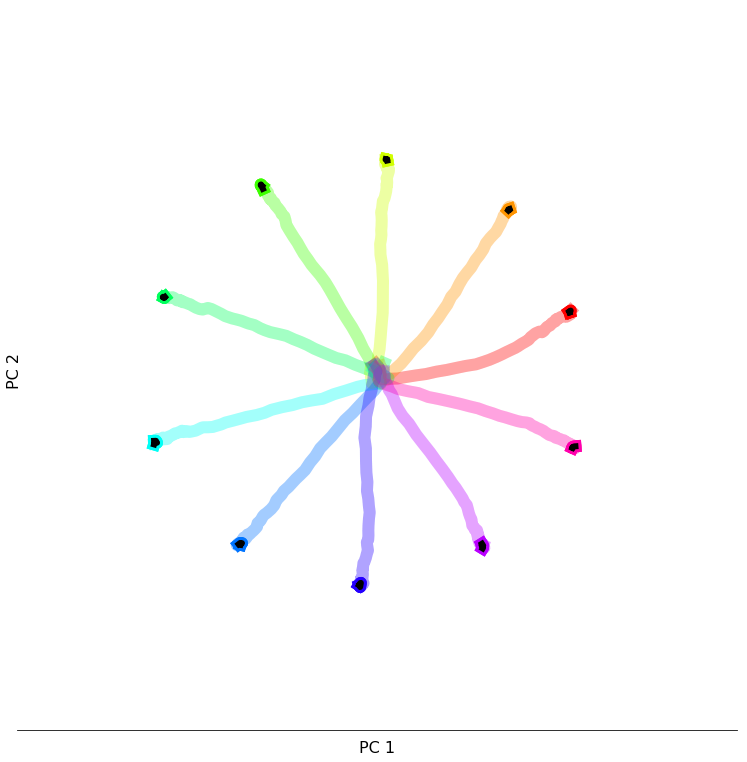

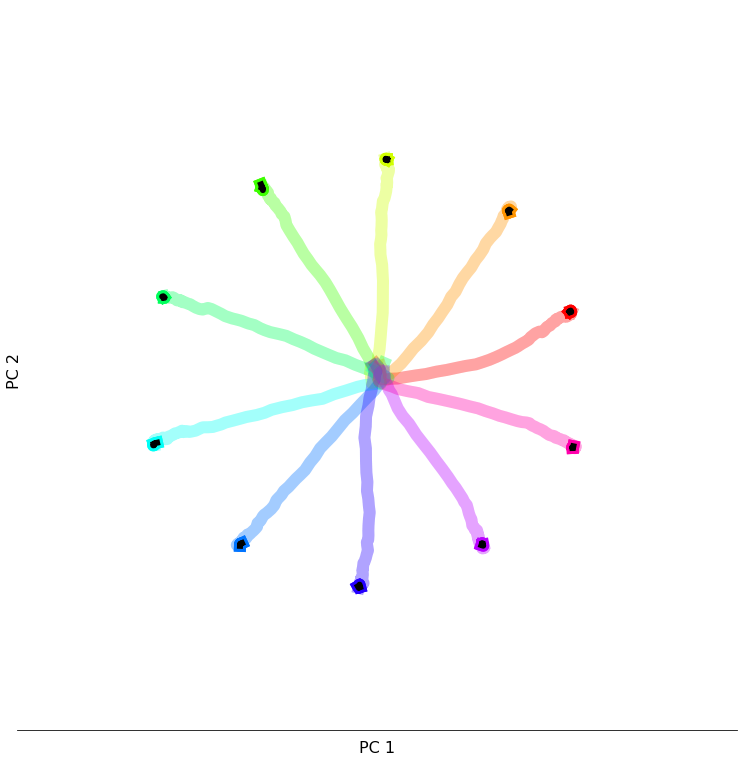

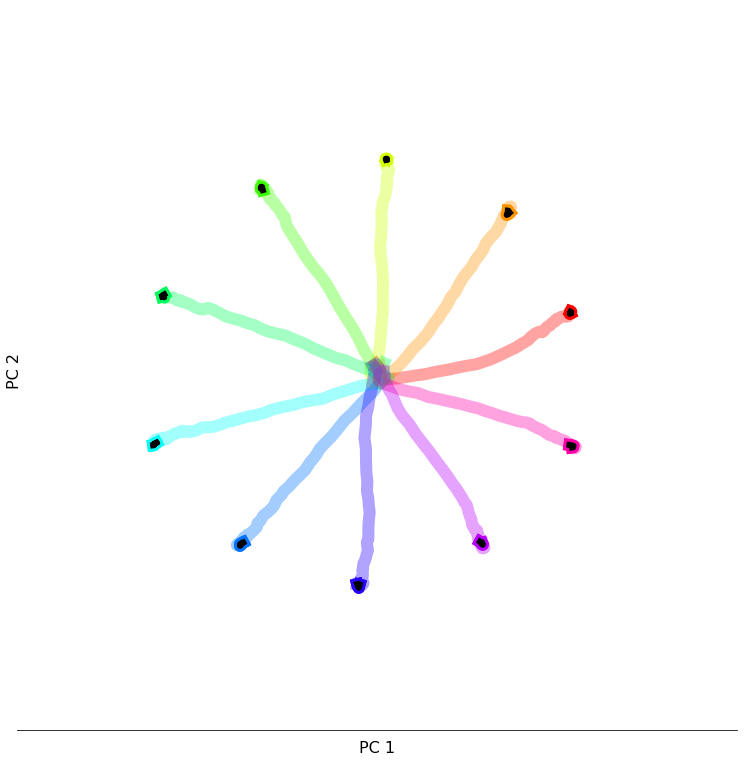

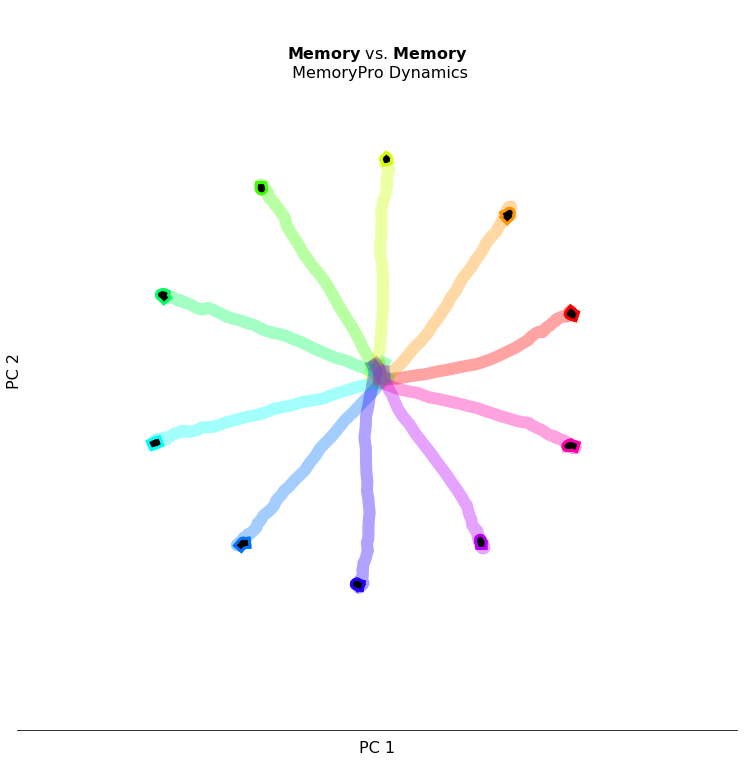

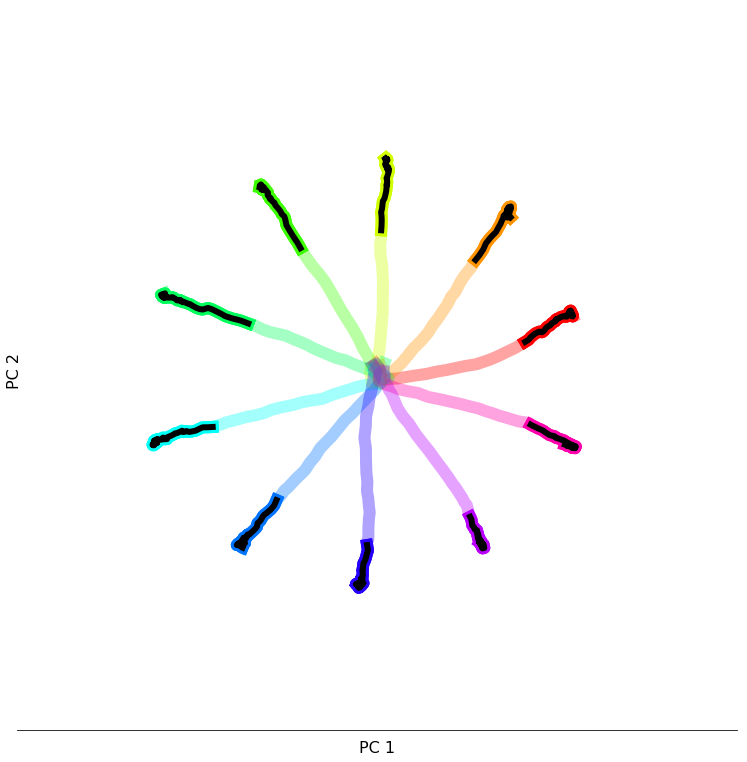

In [9]:
fig_size = 10
epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'

ax_labels = {}
ax_labels[0] = 'PC 1'
ax_labels[1] = 'PC 2'

q_thresh = 1e-7

lim = 1
lims = [-lim,lim,-lim,lim]

lims = bifurc_mov(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,threeD = False,
         n_skip_interps=1,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = lims, view_ang = [31,-52], plot_fps = False, n_trials = 10, bifurc = False)

lims = bifurc_mov(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,threeD = False,
         n_skip_interps=1,color_stim = False,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = lims, view_ang = [31,-52], plot_fps = True, n_trials = 10, bifurc = False)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

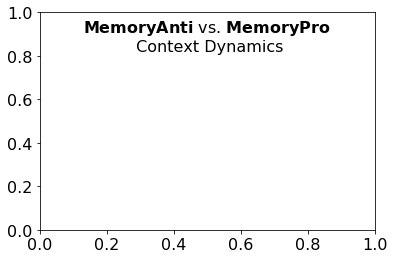

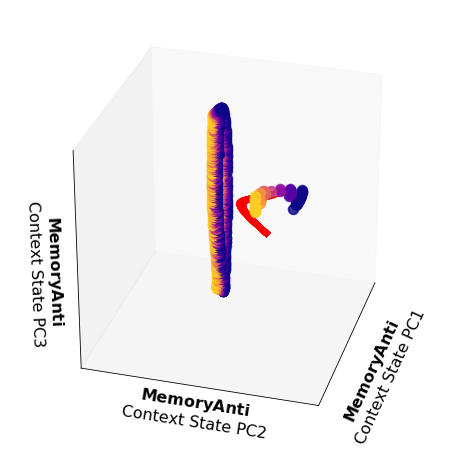

In [189]:
q_thresh = 1e-7
interp = True
fig_size = 5
script_name = 'interp_tasks_small_init_stim'
epoch_set = ['delay1','delay1']

fig_size = 6
fontsize = 18
n_trials = 8

ax_labels = ax_labels_master

lims = bifurc_mov_interp(m, D_use, rule_set, epoch_set, script_name = script_name,
         q_thresh = q_thresh, rule_axs = rule_axs, plot_unstable = True, title_y = .8,
         n_skip_interps=range(0,20,3), color_stim = True, fig_size = fig_size, fontsize = 16,
         figpath = figpath, ruleset = ruleset, al_fp = .8,ax_labels = ax_labels, stability_thresh = 1.05,
          view_ang = [29,-158],bifurc = False, plot_fps = True, pause = 0)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

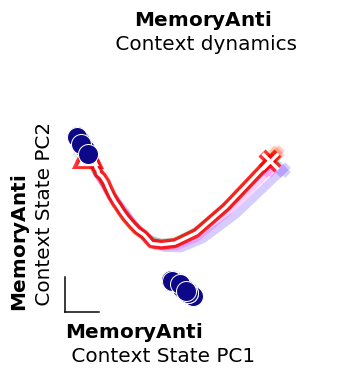

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

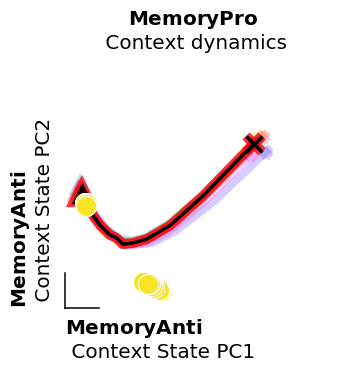

In [23]:
interp = True
fig_size = 6

epoch_set = ['fix1','fix1']
script_name = 'interp_tasks_small_init_stim'

ax_use = [0,1,2]
D_rotate = D_use[:,ax_use]
ax_labels = [ax_labels_master[alm] for alm in ax_use]

ax_labels[2] = ax_labels_master[1] 
ax_labels[1] = ax_labels_master[0] 
ax_labels[0] = r"Rule Input $\alpha$"

# bifurc(m,D_rotate,rule_set,epoch_set,script_name = script_name,q_thresh = q_thresh, rule_axs = rule_axs, 
#        color_stim = True, fig_size = fig_size,fontsize = 16, figpath = figpath, ruleset = ruleset,
#        ax_labels = ax_labels, stability_thresh = 1.05, lims = [])

plot_bifurc_ends(m, D_rotate, rule_set, epoch_set, script_name, lims = [], fac_mult_lims = 2,
                 stability_thresh = 1.05, fp_first = False, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])

In [19]:
def bifurc_mov_interp(m,D_use,rule_set,epoch_set,t_set = [0,0],script_name = 'interp_tasks_small_init_mov',
           cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['w','k'],q_thresh = .001,
           n_skip_interps=1, rule_axs = 0,ax_labels = 'pca_h', plot_unstable = True,
           color_stim = True,fig_size = 4, fontsize = 20, figpath = [],ruleset = [],
           title_y = .9, n_interp = 20,n_trials = 0, stability_thresh = 1, threeD = True,
           lims = [], view_ang = [],lw = 6,ms = 6,linestyle = '-',al_state = 1,al_fp = 1, 
           bifurc = True, plot_zero_plane = False, tol_q = 1e-6,plot_fps = True, pause = 0):
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp
    
    LAG = 2 
    plt.rcParams.update({'font.size': fontsize})

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
    
    tit, tit_name, tit_save = title_label_bifurc(bifurc,epoch_name1,epoch_name2,rule_name1,
                                                 rule_name2,ruleset,title_y,fontsize)

    T_inds = get_T_inds(trial1,epoch_set[0])
    inputs_1 = trial1.x[:T_inds[-1],t_set[0],:]
    inputs_2 = trial2.x[:T_inds[-1],t_set[1],:]
    del_inputs = inputs_2 - inputs_1

    movie_dir = os.path.join(figpath,tit_save,tit_name)
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)

    trial = trial1
    T_inds = get_T_inds(trial,epoch_set[0])   
    _,h = gen_X_from_model_dir(m,trial)
    h_epoch = np.transpose(h,(1,2,0))

    #get state colors
    cmap_state = plt.get_cmap('hsv')
    if color_stim:
        c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
        s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
        c = cmap_state(c_set[s]/(2*np.pi))
    else:
        c_set = trial.y_loc[-1,:]
        s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
        c = cmap_state(c_set[s]/(2*np.pi))

    mov_i = 0
    
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    if threeD:
        ax = fig.add_axes([0,0,1,1], projection='3d');
    else:
        ax = fig.add_axes([0,0,1,1]);

    axis_label_bifurc(ax,ax_labels,rule_name_ax,epoch_name_ax,bifurc,threeD,fontsize) 
    adjust_ax(ax,lims,threeD,bifurc,plot_zero_plane,view_ang)
            
    for step_i in n_skip_interps:#range(0,n_interp,n_skip_interps):
        c_grad = cmap_grad(step_i/n_interp)
        cd = plt.get_cmap('Greys')(step_i/n_interp)
        
        #plot fp trial
        step_inputs = inputs_1+del_inputs*(step_i/n_interp)
        x_t = step_inputs
        h0 = h_epoch[t_set[0],0,:]
        h_traj_full = vanilla_run_with_h0(params, x_t, h0, hparams)
        h_traj = h_traj_full

        #plot fp trial
        h_traj = np.dot(h_traj_full,D_use)
        if bifurc:
            h_traj[:,2] = h_traj[:,1]
            h_traj[:,1] = h_traj[:,0]
            h_traj[:,0] = (step_i/n_interp)*np.ones(len(h_traj))
                
        #plot fps
        fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                              filename_interp+'_step_'+str(step_i)+'.npz')
        fp_struct = np.load(fp_dir)
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)

        for fp_ind in range(len(fp_inds)):

            fp = np.dot(sorted_fps[fp_ind,:],D_use)
            facecolors_3d = c_grad
            fp_s = 90

            if bifurc:
                fp[2] = fp[1]
                fp[1] = fp[0]
                fp[0] = step_i/n_interp

            #sometimes we don't want to distinguish marginally stable fps so threshold is variable
            if np.max(eig_decomps[fp_ind]['evals'])>stability_thresh:
                if plot_unstable:
                    #open circles for unstable
                    facecolors_3d = 'w'
                    if threeD:
                        ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c_grad,
                           facecolors = facecolors_3d, linewidth = 1/3, alpha = al_fp)
                    else:
                        ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c_grad,
                           facecolors = facecolors_3d, linewidth = lw/2, alpha = al_fp)
            else:
                if threeD:
                    ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c_grad,
                           facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                else:
                    ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c_grad,
                           facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                    
        for im_num in T_inds[0:-1:2]:

            #trial inds
            plot_set_start = np.max([T_inds[0],im_num-LAG])
            plot_set = range(plot_set_start,im_num+2)
            
#             print(plot_set)

            plot_bifurc(ax, h_traj, threeD, plot_set, c = c, cd = cd, lw = lw, ms = ms)

            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png',bbox_inches='tight', dpi=300)
    
    if threeD:
        for turn in range(0,180,6):
            ax.view_init(elev=view_ang[0], azim=view_ang[1]+turn)    
            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png',bbox_inches='tight', dpi=300)
            
    if pause>0:
        for p_i in range(pause):
            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png',bbox_inches='tight', dpi=300)
        
    images = []
    for t in range(1,mov_i):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))

    imageio.mimsave(movie_dir+'/movie.gif', images)

    return lims


In [28]:
# from tools
tol_q = 1e-6
script_name = 'interp_tasks_small_init_mov'
epoch_set = ['delay1','delay1']
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
trial2 = gen_trials_from_model_dir(m,rule_str[1],mode='test',noise_on = False)
trial2 = same_mov_inds(trial1, trial2) 
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
        
fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                      filename_interp+'_step_'+str(0)+'.npz')
fp_struct = np.load(fp_dir)
sorted_fps = fp_struct['xstar']

pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(sorted_fps)
D_use = pca.components_.T
ax_labels = 'pca_fp'

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC1',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC2',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC3',]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

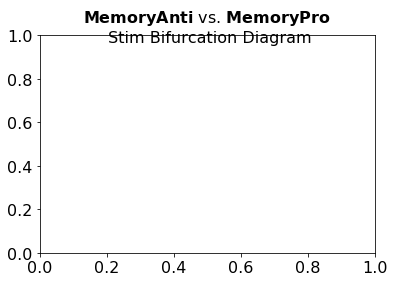

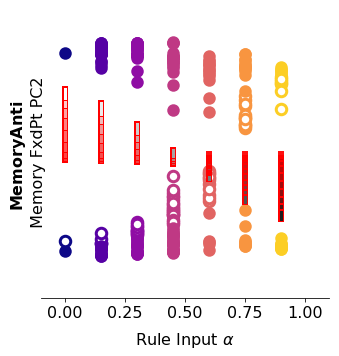

In [29]:
from tools_lnd import make_D_use, interp3d, take_names, vanilla_run_with_h0

fig_size = 4
q_thresh = .00001
interp = True
epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'

ax_use = [0,1,2]
D_rotate = D_use[:,ax_use]
ax_labels = [ax_labels_master[alm] for alm in ax_use]

ax_labels[0] = r"Rule Input $\alpha$"

lims = bifurc_mov_interp(m,D_rotate,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
       q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .95,
       n_skip_interps=range(0,20,3),color_stim = True,fig_size = fig_size,fontsize = 16,
       figpath = figpath,ruleset = ruleset,ax_labels = ax_labels,
       stability_thresh = 1, lims = [-.1,1.1,-.8,.8], threeD = False, plot_fps = True, pause = 20)

ax_use = [1,0,2]
D_rotate = D_use[:,ax_use]
ax_labels = [ax_labels_master[alm] for alm in ax_use]

# plot_bifurc_ends(m,D_rotate,rule_set,epoch_set,script_name, lims = [],q_thresh = q_thresh,
#                  figpath = figpath, ruleset = ruleset,ax_labels = [ax_labels_master[0],ax_labels_master[1]])

In [30]:
def bifurc_mov(m,D_use,rule_set,epoch_set,t_set = [0,0],script_name = 'interp_tasks_small_init_mov',
           cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['w','k'],q_thresh = .001,
           n_skip_interps=1, rule_axs = 0,ax_labels = 'pca_h', plot_unstable = True,
           color_stim = True,fig_size = 4, fontsize = 20, figpath = [],ruleset = [],
           title_y = .9, n_interp = 20,n_trials = 0, stability_thresh = 1, threeD = True,
           lims = [], view_ang = [],lw = 6,ms = 6,linestyle = '-',al_state = 1,al_fp = 1, 
           bifurc = True, plot_zero_plane = False, tol_q = 1e-6,plot_fps = True):
    
    LAG = 5 
    plt.rcParams.update({'font.size': fontsize})

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
    
    tit, tit_name, tit_save = title_label_bifurc(bifurc,epoch_name1,epoch_name2,rule_name1,
                                                 rule_name2,ruleset,title_y,fontsize)

    movie_dir = os.path.join(figpath,tit_save,tit_name)
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)

    T_inds = get_T_inds(trial1,epoch_set[0])
    movie_inds = T_inds[0:-1:1] #frame every 6 timesteps
    
#     if plot_fps:
#         mov_i = len(movie_inds)
#     else:
        
    mov_i = 0
        
#     for im_num in T_inds:
        
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    if threeD:
        ax = fig.add_axes([0,0,1,1], projection='3d');
    else:
        ax = fig.add_axes([0,0,1,1]);
            
    axis_label_bifurc(ax,ax_labels,rule_name_ax,epoch_name_ax,bifurc,threeD,fontsize)    
    adjust_ax(ax,lims,threeD,bifurc,plot_zero_plane,view_ang)

    #plot fps
    if plot_fps:
        for step_i in range(0,n_interp,n_skip_interps):
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                fp = np.dot(sorted_fps[fp_ind,:],D_use)
                facecolors_3d = c
                fp_s = 50

                if bifurc:
                    fp[2] = fp[1]
                    fp[1] = fp[0]
                    fp[0] = step_i/n_interp

                #sometimes we don't want to distinguish marginally stable fps so threshold is variable
                if np.max(eig_decomps[fp_ind]['evals'])>stability_thresh:
                    if plot_unstable:
                        #open circles for unstable
                        facecolors_3d = 'w'
                        if threeD:
                            ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = 1/3, alpha = al_fp)
                        else:
                            ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = lw/2, alpha = al_fp)
                else:
                    if threeD:
                        ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                    else:
                        ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                        
            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png', dpi=300)
    
    if threeD:
        for turn in range(0,180,6):
            ax.view_init(elev=view_ang[0], azim=view_ang[1]+turn)    
            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png', dpi=300)
        
    images = []
    for t in range(1,mov_i):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))

    imageio.mimsave(movie_dir+'/movie.gif', images)

    return lims


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

OSError: No such file: '/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/fig1/fig1_two_task_bifurc_mov/bifurcation/mem_motifs_small_MemoryAnti_v_MemoryPro_Memory_bifurcation/ends/10.png'

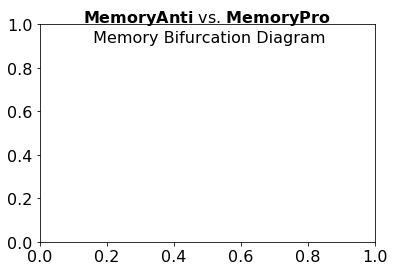

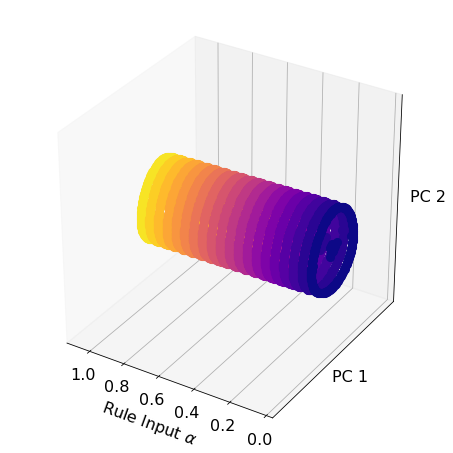

In [34]:
fig_size = 6
epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'

ax_labels = {}
ax_labels[1] = 'PC 1'
ax_labels[2] = 'PC 2'
ax_labels[0] = r"Rule Input $\alpha$"

q_thresh = .0001

lims = bifurc_mov(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = [-.01,1.01,-.8,.8,-.8,.8], view_ang = [31,-52], plot_fps = True)

# plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [], fac_mult_lims = 2, q_thresh = q_thresh,
#                  stability_thresh = 1.05,color_stim = True, figpath = figpath, ruleset = ruleset,
#                 ax_labels = [ax_labels[1],ax_labels[2]])

In [10]:
tol_q = 1e-6
script_name = 'interp_tasks_small_init_mov'
epoch_set = ['go1','go1']
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
trial2 = gen_trials_from_model_dir(m,rule_str[1],mode='test',noise_on = False)
trial2 = same_mov_inds(trial1, trial2) 
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
        
fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                      filename_interp+'_step_'+str(0)+'.npz')
fp_struct = np.load(fp_dir)
sorted_fps = fp_struct['xstar']

pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(sorted_fps)
D_use = pca.components_.T
ax_labels = 'pca_fp'

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC1',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC2',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC3',]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

In [32]:
from tools_lnd import same_stim_trial, load_fps_from_interp, plot_FPs, gen_X_from_model_dir, get_T_inds, plot_N, make_lil_axes
def plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name,tol_q = 1e-6,t_set = [0,0],
                     q_thresh = .0000001,fig_size = 4, lims = [], fac_mult_lims = 1.5,
                     stability_thresh = 1,fp_first = True, color_stim = True, step_set = [0,19],
                     figpath = 'plot_bifurc_ends',ruleset = 'all',fontsize = 20, 
                     plot_unstable = True,plot_expansion = False,ax_labels = []):
    
    cmap_discrete = ['w','k']
    cmap_grad = plt.get_cmap('plasma')

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))

    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
    trial_set = [trial1, trial2]

    trial_inds = range(0,np.shape(trial1.x)[1],int(np.shape(trial1.x)[1]/8))

    for ri in [0,1]:
        fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
        ax = fig.add_axes([0,0,1,1])

        sorted_fps, eig_decomps = load_fps_from_interp(m,script_name,rule_str,tol_q,filename_interp,
                                                         step_set[ri],q_thresh)

        if fp_first:
            plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
                stability_thresh = stability_thresh, plot_unstable = plot_unstable,
                plot_expansion = plot_expansion)
        
        rule = rule_str[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]
        print(c_master)

        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        T_inds_plot = range(np.max([T_inds[0]-1,0]),T_inds[-1])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))


        cmap_state = plt.get_cmap('hsv')
        if color_stim:
            c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
            s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))
        else:
            c_set = trial.y_loc[-1,:]
            s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))

        lw = 10
        plot_N(x_epoch[trial_inds,:,:], D_use.T, c_set[trial_inds], linewidth = fig_size*2, alpha = .2)
        plot_N(x_epoch[[s,],:,:], D_use.T, c, linewidth = lw, alpha = .8 ,markersize = 16)
        plot_N(x_epoch[[s,],:,:], D_use.T, c_master, linewidth = lw/3, alpha = 1 ,markersize = 16)

        if not fp_first:
            plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
                stability_thresh = stability_thresh, plot_unstable = plot_unstable,
                plot_expansion = plot_expansion)

        if len(lims)>0:
            ax.set_xlim([fac_mult_lims*lims[0],fac_mult_lims*lims[1]])
            ax.set_ylim([fac_mult_lims*lims[2],fac_mult_lims*lims[3]])
        else:
            # [x1,x2] = ax.get_xlim()
            # [y1,y2] = ax.get_ylim()
            # ax.set_xlim([x1-.2*abs(x1),x2+.2*abs(x2)])
            # ax.set_ylim([y1-.2*abs(y1),y2+.2*abs(y2)])
            
            ax.set_ylim([-1.15,1.15])
            ax.set_xlim([-1.15,1.15])

        epoch_name, rule_name, _, _ = take_names(epoch_set[ri],rule_str[ri])
        
        ax.set_ylim([-1.2,1.2])
        ax.set_xlim([-1.2,1.2])
        
        if len(ax_labels)>0:
            make_lil_axes(ax,ax_labels)

        ax.set_ylim([-1.2,1.2])
        ax.set_xlim([-1.2,1.2])

        tit = r"$\bf{"+rule_name+"}$"+'\n '+epoch_name+' dynamics'
        tit_name = rule_name+'_'+epoch_name+'_dynamics'
        plt.title(tit,fontsize = fontsize)#,y = .9
        fig_fldr = os.path.join(figpath,'interp_fps',ruleset,'bifurcation')
        if not os.path.exists(fig_fldr):
            os.makedirs(fig_fldr)

        plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
        plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'), dpi=300)
        plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

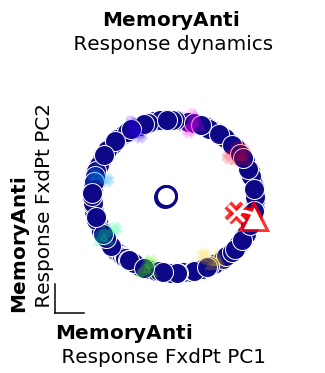

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

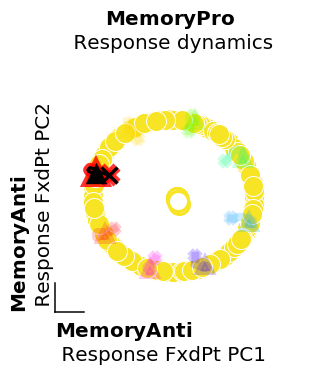

In [33]:
D_use = np.zeros((256,3))

fig_size = 6
q_thresh = .1
epoch_set = ['go1','go1']
script_name = 'interp_tasks_small_init_mov'

filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                      filename_interp+'_step_'+str(0)+'.npz')

fp_struct = np.load(fp_dir)
sorted_fps = fp_struct['xstar']

pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(sorted_fps)
D_use = pca.components_.T
D_use[:,0] = -D_use[:,0]

# lims = bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
#                        lims = [], view_ang = [31,-52])

lim_fac = 2

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2, q_thresh = q_thresh,
                 stability_thresh = 1.05, color_stim = True, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels_master[0],ax_labels_master[1]])

In [ ]:
def plot_stim_angles(ax,stim_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False, show_rainbow = True):
        
    stim_cmap = plt.get_cmap('hsv')

    [x1,x2] = ax.get_xlim()
    x_diff = (x2-x1)/10
    [y1,y2] = ax.get_ylim()
    y_diff = (y2-y1)/10
    
    x_origin = x1+5*x_diff
    y_origin = y2+y_diff

    if show_rainbow:
        for theta in stim_locs:
            c = stim_cmap(theta/(2*np.pi))
            plt.plot([x_origin,x_origin+x_diff*np.cos(theta)],
                     [y_origin,y_origin+y_diff*np.sin(theta)],'-',c = c,alpha = .5,linewidth = 5)
        
        if show_stim:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.2,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Stimulus '+r'$\theta$',fontsize = 16,fontweight ='bold')
        else:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.4,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Response '+r'$\theta$',fontsize = 16,fontweight ='bold')
    
    
    if cat_task:
        plt.text(x_origin+x_diff*np.cos(0),y_origin-y_diff*np.sin(np.pi/2),'Category \n Boundary',fontsize = 14)
        plt.plot([x_origin-x_diff*np.cos(np.pi),x_origin+x_diff*np.cos(np.pi)],
                 [y_origin-y_diff*np.sin(np.pi),y_origin+y_diff*np.sin(np.pi)],':k',alpha = .9,linewidth = 3)
        
    if two_task:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = cmap_discrete[1],alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = cmap_discrete[1],alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,'Task1',fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = cmap_discrete[1],alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = cmap_discrete[0],alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = cmap_discrete[0],alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = cmap_discrete[0],alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,'Task2',fontsize = 14,verticalalignment='center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])


In [ ]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(.4,.5),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
stim1_locs = np.min(trial.stim_locs[0:-1:10,[0,2]],axis=1) #only workds for single modality tasks
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = True, show_rainbow = False)

figname = 'task_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'task_legend.png'
plt.savefig(os.path.join(figpath,figname), dpi=300)
plt.show()

In [ ]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False)

figname = 'stim_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'stim_angle_legend.png'
plt.savefig(os.path.join(figpath,figname), dpi=300)
plt.show()

In [ ]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = False)

figname = 'response_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'response_angle_legend.png'
plt.savefig(os.path.join(figpath,figname), dpi=300)
plt.show()

In [ ]:
def interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
    cmap = plt.get_cmap('plasma')
    for step_i in range(0,n_interp,n_skip_interps):
        c = cmap(step_i/n_interp)
        ax.scatter(step_i-21.5,0,s = 200,marker = 'o',edgecolors = c,facecolors = c,alpha = al)
    plt.text(-n_interp-3,-.06,'DelayPro ---> DelayAnti',fontsize = 14,fontweight ='bold')
    plt.text(-2*n_interp-4,-.06,'Rule Input Interpolation \n   Stable Fixed Points:',fontsize = 14,fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])
#     [x1,x2] = ax.get_xlim()
#     [y1,y2] = ax.get_ylim()
#     ax.set_xlim([y1-3,y2])
    
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(2.6,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)

figname = 'interp_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'interp_legend.png'
plt.savefig(os.path.join(figpath,figname), dpi=300)
plt.show()